In [1]:
import numpy as np
import pandas as pd

import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/data-fusion-2024-churn-features-6/__results__.html
/kaggle/input/data-fusion-2024-churn-features-6/main_tsf.csv
/kaggle/input/data-fusion-2024-churn-features-6/main_ft.csv
/kaggle/input/data-fusion-2024-churn-features-6/__notebook__.ipynb
/kaggle/input/data-fusion-2024-churn-features-6/__output__.json
/kaggle/input/data-fusion-2024-churn-features-6/custom.css
/kaggle/input/data-fusion-2024-churn-features-6/catboost_info/learn_error.tsv
/kaggle/input/data-fusion-2024-churn-features-6/catboost_info/catboost_training.json
/kaggle/input/data-fusion-2024-churn-features-6/catboost_info/time_left.tsv
/kaggle/input/data-fusion-2024-churn-features-6/catboost_info/learn/events.out.tfevents
/kaggle/input/ods-churn-24/currency_rk.csv
/kaggle/input/ods-churn-24/report_dates.csv
/kaggle/input/ods-churn-24/mcc_codes.csv
/kaggle/input/ods-churn-24/clients.csv
/kaggle/input/ods-churn-24/train.csv
/kaggle/input/ods-churn-24/sample_submit_naive.csv
/kaggle/input/ods-churn-24/transactions.cs

In [2]:
!pip install scikit-survival

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.0/299.0 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [3]:
import pandas as pd
import numpy as np
from sksurv.ensemble import RandomSurvivalForest
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import random
import warnings
from IPython.display import display, HTML

pd.set_option('display.max_columns', None)
warnings.simplefilter('ignore')
# pd.options.display.max_columns = 100
# pd.options.display.max_rows = 100
random.seed(42)
np.random.seed(42)

In [4]:
def merge_by_concat(df1, df2, merge_on):
    merged_gf = df1[merge_on]
    merged_gf = merged_gf.merge(df2, on=merge_on, how='left')
    new_columns = [col for col in list(merged_gf) if col not in merge_on]
    df1 = pd.concat([df1, merged_gf[new_columns]], axis=1)
    return df1

### Load data. EDA

In [5]:
!ls '/kaggle/input/ods-churn-24'

clients.csv	 mcc_codes.csv	   sample_submit_naive.csv  transactions.csv
currency_rk.csv  report_dates.csv  train.csv


In [6]:
clients = pd.read_csv('/kaggle/input/ods-churn-24/clients.csv')

In [7]:
clients

,user_id,report,employee_count_nm,bankemplstatus,customer_age
0,3,2,ОТ 101 ДО 500,0,3
1,9,1,БОЛЕЕ 1001,0,3
2,13,6,ОТ 501 ДО 1000,0,2
3,37,5,БОЛЕЕ 1001,0,2
4,41,1,ОТ 101 ДО 500,0,2
...,...,...,...,...,...
95995,562043,12,NaN,0,2
95996,562205,12,NaN,0,1
95997,562312,12,NaN,0,0
95998,562721,12,NaN,0,2


In [8]:
clients.groupby('user_id')[['report']].count().sort_values(by='report')

,report
user_id,
3,1
370191,1
370183,1
370176,1
370174,1
...,...
184890,1
184884,1
184883,1


In [9]:
clients.groupby('employee_count_nm', dropna=False)[['report']].count().assign(report_share=lambda x: x.report/x.report.sum()*100)

,report,report_share
employee_count_nm,,
БОЛЕЕ 1001,17833,18.576042
БОЛЕЕ 500,1996,2.079167
ДО 10,3797,3.955208
ОТ 101 ДО 500,14362,14.960417
ОТ 11 ДО 30,1871,1.948958
ОТ 11 ДО 50,4413,4.596875
ОТ 31 ДО 50,1467,1.528125
ОТ 501 ДО 1000,6481,6.751042
ОТ 51 ДО 100,7314,7.618750


In [10]:
clients.groupby('report', dropna=False)[['user_id']].count()

,user_id
report,
1,7513
2,7660
3,7787
4,7853
5,7929
6,7974
7,8106
8,8119
9,8164


In [11]:
clients.groupby('bankemplstatus', dropna=False)[['user_id']].count()

,user_id
bankemplstatus,
0,95687
1,313


In [12]:
clients.groupby('customer_age', dropna=False)[['user_id']].count()

,user_id
customer_age,
0,24401
1,19165
2,21470
3,30964


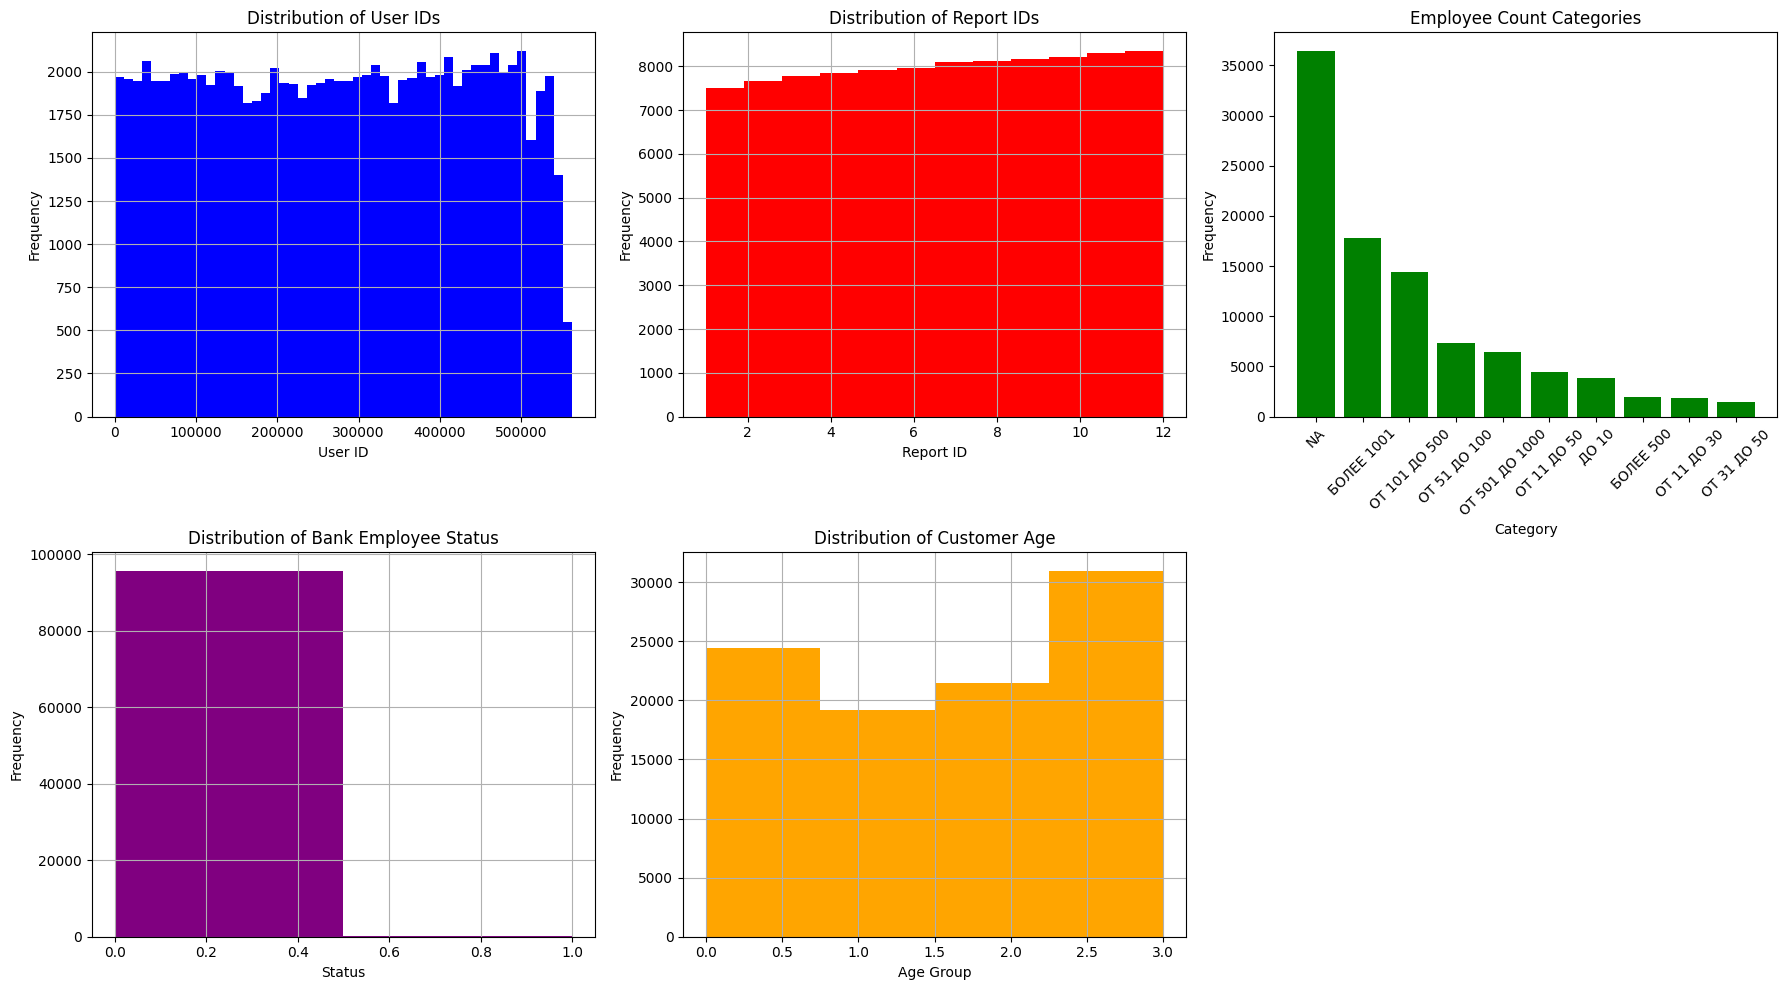

In [13]:
# Setting up the plotting area
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.delaxes(axes[1,2]) # Remove the extra subplot space

# Plot for user_id
axes[0, 0].hist(clients['user_id'], bins=50, color='blue')
axes[0, 0].set_title('Distribution of User IDs')
axes[0, 0].set_xlabel('User ID')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True)

# Plot for report
axes[0, 1].hist(clients['report'], bins=clients['report'].nunique(dropna=False), color='red')
axes[0, 1].set_title('Distribution of Report IDs')
axes[0, 1].set_xlabel('Report ID')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True)

# Plot for employee_count_nm
employee_counts = clients['employee_count_nm'].fillna('NA').value_counts(dropna=False)
axes[0, 2].bar(employee_counts.index, employee_counts.values, color='green')
axes[0, 2].set_title('Employee Count Categories')
axes[0, 2].set_xlabel('Category')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].tick_params(axis='x', rotation=45)

# Plot for bankemplstatus
axes[1, 0].hist(clients['bankemplstatus'], bins=clients['bankemplstatus'].nunique(dropna=False), color='purple')
axes[1, 0].set_title('Distribution of Bank Employee Status')
axes[1, 0].set_xlabel('Status')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True)

# Plot for customer_age
axes[1, 1].hist(clients['customer_age'], bins=clients['customer_age'].nunique(dropna=False), color='orange')
axes[1, 1].set_title('Distribution of Customer Age')
axes[1, 1].set_xlabel('Age Group')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()


In [14]:
# employee_count_nm (число людей в компании) - почти 40% нулы
# bankemplstatus (статус работника банка) - почти все не работники банка
# Всё остальное +- равномерно распределено

In [15]:
report_dates = pd.read_csv('/kaggle/input/ods-churn-24/report_dates.csv', parse_dates=['report_dt'])

In [16]:
report_dates

,report,report_dt
0,1,2022-07-31 03:00:00
1,2,2022-08-31 03:00:00
2,3,2022-09-30 03:00:00
3,4,2022-10-31 03:00:00
4,5,2022-11-30 03:00:00
5,6,2022-12-31 03:00:00
6,7,2023-01-31 03:00:00
7,8,2023-02-28 03:00:00
8,9,2023-03-31 03:00:00
9,10,2023-04-30 03:00:00


In [17]:
%%time
transactions = pd.read_csv('/kaggle/input/ods-churn-24/transactions.csv', parse_dates=['transaction_dttm'])

CPU times: user 21.5 s, sys: 1.87 s, total: 23.4 s
Wall time: 29.5 s


In [18]:
transactions

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
0,3,3,1,-183.883957,2022-01-28 12:05:33
1,3,3,1,-3206.437012,2022-01-28 12:52:30
2,3,16,1,-153866.890625,2022-02-16 14:45:56
3,3,56,1,-15144.601562,2022-03-09 19:58:29
4,3,0,1,5297.908691,2022-03-12 18:11:31
...,...,...,...,...,...
13075018,562740,155,1,-2484.366211,2023-03-20 11:52:09
13075019,562740,9,1,-187.658463,2023-03-20 12:10:22
13075020,562740,1,1,-891.933350,2023-03-20 15:53:37
13075021,562740,13,1,-464.467316,2023-03-20 15:54:49


In [19]:
for col in transactions.columns:
    print(transactions[transactions[col].isna()].shape[0])

# Нет нулов

0
0
0
0
0


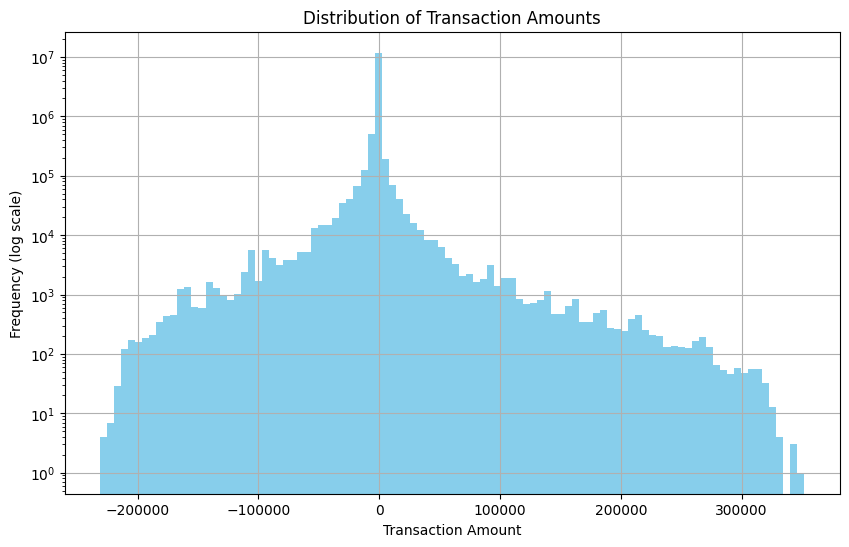

In [20]:
# Plotting the distribution of transaction amounts
plt.figure(figsize=(10, 6))
plt.hist(transactions['transaction_amt'], bins=100, color='skyblue')
plt.yscale('log') # Using a logarithmic scale due to wide range of transaction amounts
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency (log scale)')
plt.grid(True)
plt.show()

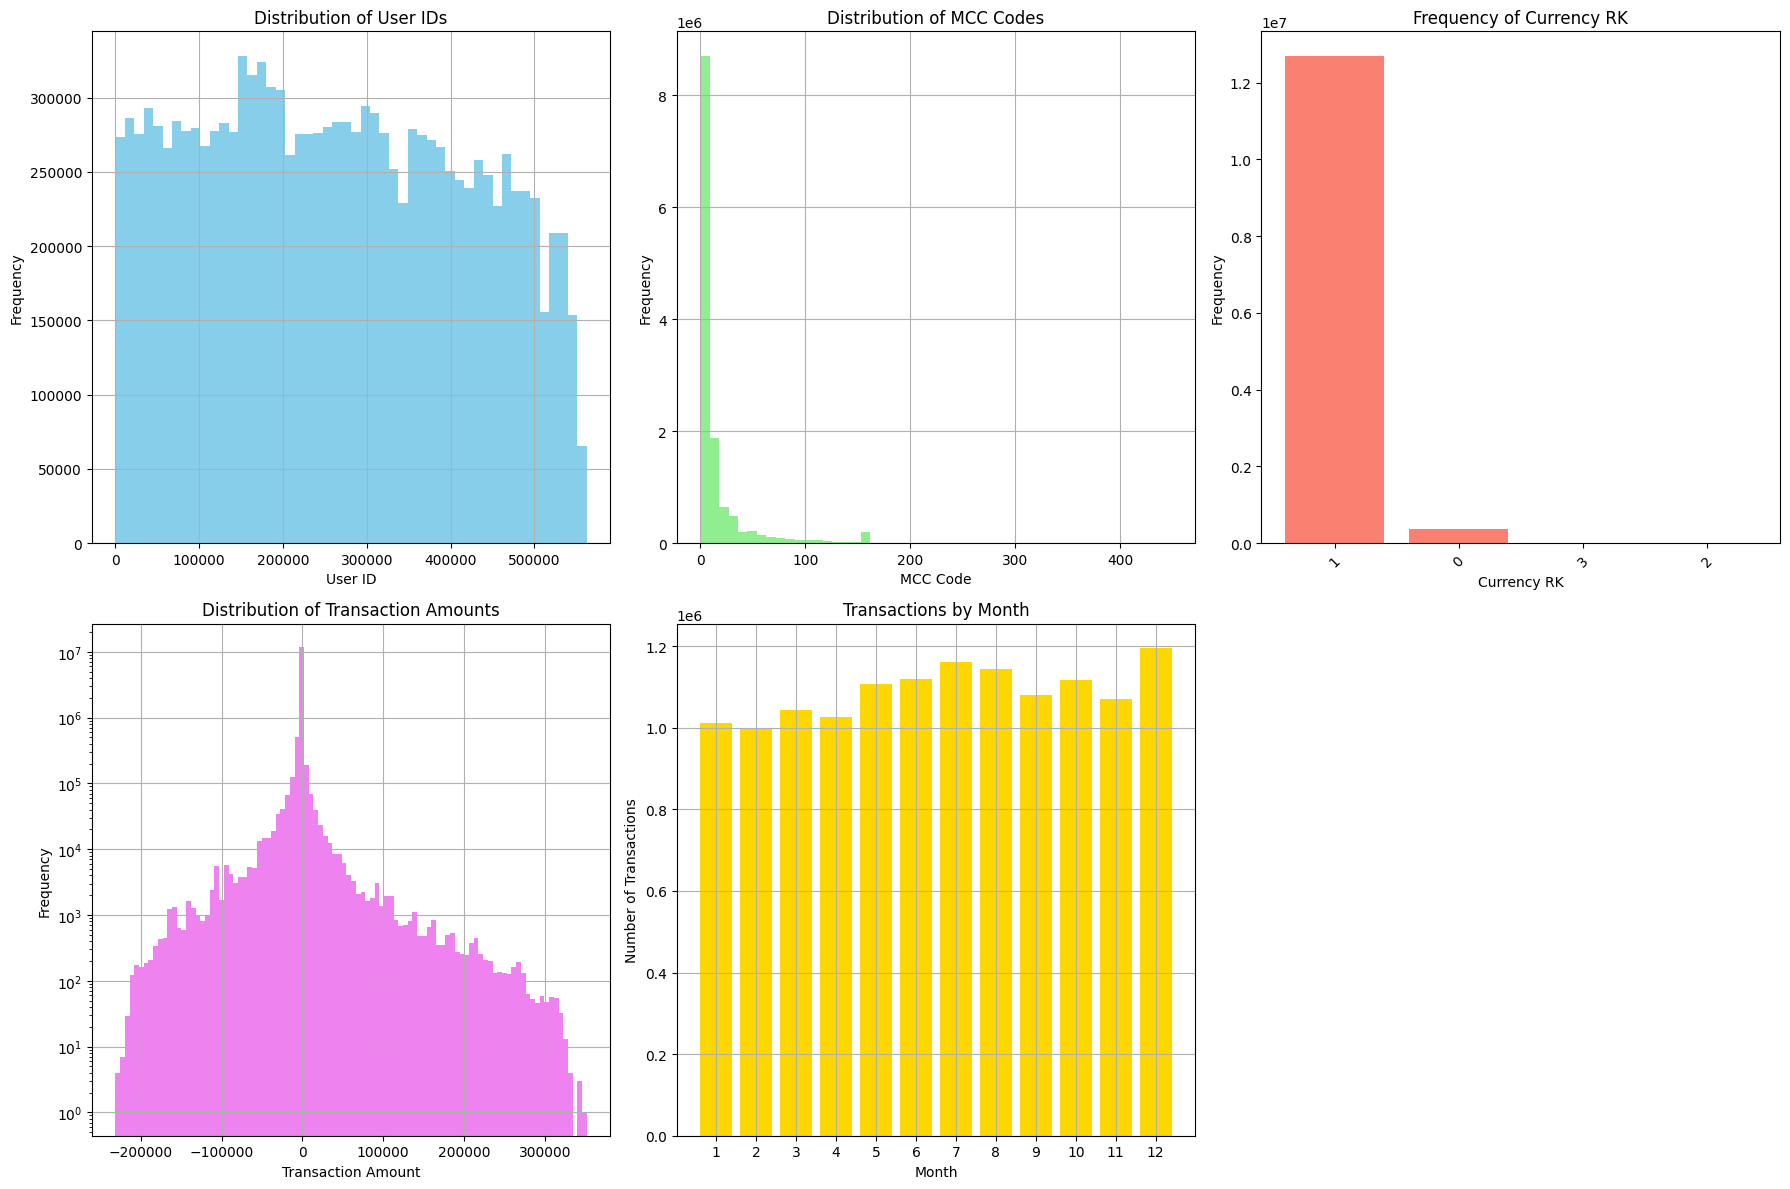

In [21]:
# Convert transaction_dttm to datetime to extract components
transactions_df = transactions.copy()
transactions_df['transaction_dttm'] = pd.to_datetime(transactions_df['transaction_dttm'])
transactions_df['month'] = transactions_df['transaction_dttm'].dt.month

# Setting up the plotting area
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
fig.delaxes(axes[1,2]) # Remove the extra subplot space

# Plot for user_id
axes[0, 0].hist(transactions_df['user_id'], bins=50, color='skyblue')
axes[0, 0].set_title('Distribution of User IDs')
axes[0, 0].set_xlabel('User ID')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True)

# Plot for mcc_code
axes[0, 1].hist(transactions_df['mcc_code'], bins=50, color='lightgreen')
axes[0, 1].set_title('Distribution of MCC Codes')
axes[0, 1].set_xlabel('MCC Code')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True)

# Plot for currency_rk
currency_counts = transactions_df['currency_rk'].value_counts()
axes[0, 2].bar(currency_counts.index.astype(str), currency_counts.values, color='salmon')
axes[0, 2].set_title('Frequency of Currency RK')
axes[0, 2].set_xlabel('Currency RK')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].tick_params(axis='x', rotation=45)

# Plot for transaction_amt
axes[1, 0].hist(transactions_df['transaction_amt'], bins=100, color='violet')
axes[1, 0].set_title('Distribution of Transaction Amounts')
axes[1, 0].set_xlabel('Transaction Amount')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True)

# Plot for transaction_dttm (month)
month_counts = transactions_df['month'].value_counts().sort_index()
axes[1, 1].bar(month_counts.index.astype(str), month_counts.values, color='gold')
axes[1, 1].set_title('Transactions by Month')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Number of Transactions')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()


In [22]:
transactions['user_id'].nunique()

96000

In [23]:
transactions[transactions.transaction_amt==0]

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm


In [24]:
month_counts

month
1     1011586
2      999997
3     1042241
4     1026928
5     1107441
6     1119131
7     1160703
8     1145063
9     1079549
10    1116756
11    1070820
12    1194808
Name: count, dtype: int64

In [25]:
transactions_df['mcc_code'].value_counts()[0:20]

mcc_code
1      4152654
2      1065363
4       947720
3       719400
0       582177
11      520796
6       440264
8       418128
7       381862
9       212977
17      207845
10      197535
14      196364
13      195273
155     181282
15      153964
12      149701
26      142919
32       94779
28       85048
Name: count, dtype: int64

In [26]:
# Нет пропусков
# Популярны рубли
# Популярны mcc коды, ближайшие к 0

In [27]:
# transactions[0:500000].to_csv('transactions.csv', index=False)

In [28]:
currency_rk = pd.read_csv('/kaggle/input/ods-churn-24/currency_rk.csv')
currency_rk

# 1 — рубль
# 2,3 — евро и доллар
# 0 — все остальное

currency_mult = pd.DataFrame({'ind': [0,1,2,3], 'mult':[24,1,100,90]})
currency_mult

,ind,mult
0,0,24
1,1,1
2,2,100
3,3,90


In [29]:
mcc_codes = pd.read_csv('/kaggle/input/ods-churn-24/mcc_codes.csv')
mcc_codes.sort_values(by='MCC')
# Пока неактуальные коды

,MCC,Название,Описание
0,742,Ветеринарные услуги,Лицензированные специалисты в основном занимаю...
1,763,Сельскохозяйственные кооперативы,"Ассоциации и кооперативы, которые предоставляю..."
2,780,Услуги садоводства и ландшафтного дизайна,Ландшафтные архитекторы и другие поставщики ус...
3,1520,Генеральные подрядчики – жилое и коммерческое ...,"Генеральные подрядчики, в основном занимающиес..."
4,1711,"Генеральные подрядчики по вентиляции, теплосна...","Специальные торговые подрядчики, которые работ..."
...,...,...,...
380,9311,Налоговые платежи,"Местные, региональные и федеральные организаци..."
381,9399,Государственные услуги - нигде более не класси...,"Торговые точки, предоставляющие правительству ..."
382,9402,Почтовые услуги – только государственные,"Государственные почтовые отделения, включая ме..."
383,9405,Внутригосударственные закупки - только государ...,Определяет транзакции между правительственными...


In [30]:
sample_submit_naive = pd.read_csv('/kaggle/input/ods-churn-24/sample_submit_naive.csv')
sample_submit_naive

,user_id,predict
0,9,-3.184396
1,61,-2.623560
2,62,-2.840654
3,80,-3.269438
4,88,-2.068500
...,...,...
31995,561362,-2.438619
31996,561419,-2.438619
31997,561895,-2.437339
31998,561908,-2.437339


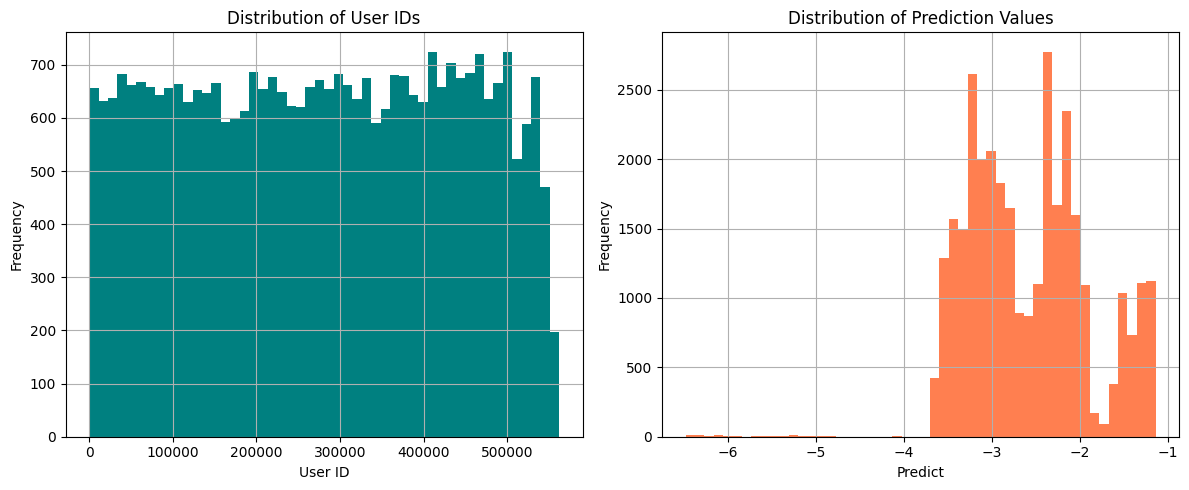

In [31]:
# Setting up the plotting area
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot for user_id
axes[0].hist(sample_submit_naive['user_id'], bins=50, color='teal')
axes[0].set_title('Distribution of User IDs')
axes[0].set_xlabel('User ID')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Plot for predict
axes[1].hist(sample_submit_naive['predict'], bins=50, color='coral')
axes[1].set_title('Distribution of Prediction Values')
axes[1].set_xlabel('Predict')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [32]:
train = pd.read_csv('/kaggle/input/ods-churn-24/train.csv')
train

,user_id,target,time
0,3,0,77
1,13,0,86
2,37,0,89
3,41,0,57
4,42,0,84
...,...,...,...
63995,561824,0,91
63996,562043,0,75
63997,562312,0,91
63998,562721,0,29


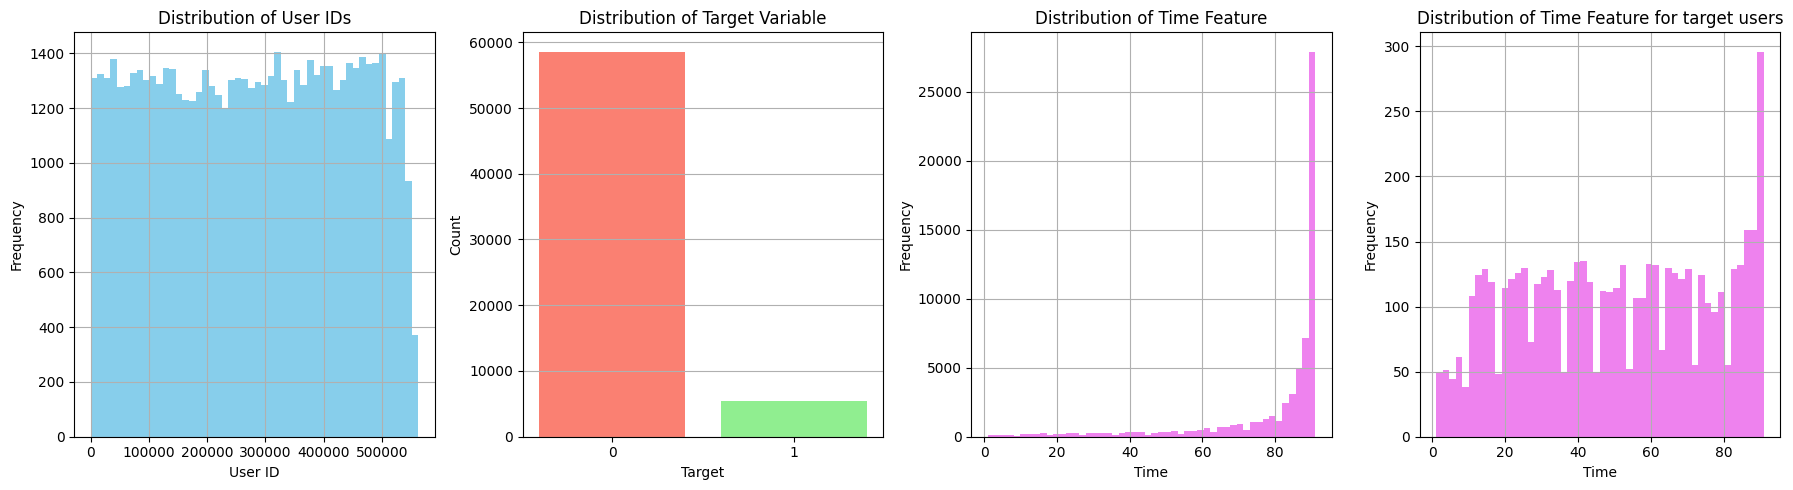

In [33]:
# Setting up the plotting area
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 5))

# Plot for user_id
axes[0].hist(train['user_id'], bins=50, color='skyblue')
axes[0].set_title('Distribution of User IDs')
axes[0].set_xlabel('User ID')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Plot for target
axes[1].bar(train['target'].value_counts().index.astype(str), train['target'].value_counts().values, color=['salmon', 'lightgreen'])
axes[1].set_title('Distribution of Target Variable')
axes[1].set_xlabel('Target')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=0)
axes[1].grid(axis='y')

# Plot for time
axes[2].hist(train['time'], bins=50, color='violet')
axes[2].set_title('Distribution of Time Feature')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Frequency')
axes[2].grid(True)

# Plot for time
axes[3].hist(train.loc[train['target'] == 1]['time'], bins=50, color='violet')
axes[3].set_title('Distribution of Time Feature for target users')
axes[3].set_xlabel('Time')
axes[3].set_ylabel('Frequency')
axes[3].grid(True)

plt.tight_layout()
plt.show()


In [34]:
train['target'].value_counts()

target
0    58583
1     5417
Name: count, dtype: int64

In [35]:
train['target'].value_counts(normalize=True)

target
0    0.915359
1    0.084641
Name: proportion, dtype: float64

In [36]:
# Разспределение валют у отточников
train[train['target'] == 1].merge(transactions, how='left').currency_rk.value_counts(normalize=True)

currency_rk
1    0.950493
0    0.048721
2    0.000588
3    0.000197
Name: proportion, dtype: float64

In [37]:
# Разспределение валют у неотточников
train[train['target'] == 0].merge(transactions, how='left').currency_rk.value_counts(normalize=True)

currency_rk
1    0.972886
0    0.026875
3    0.000132
2    0.000106
Name: proportion, dtype: float64

In [38]:
train[train['target'] == 1].merge(transactions, how='left').mcc_code.value_counts(normalize=True)[0:10]

mcc_code
1     0.296556
2     0.090596
4     0.078166
0     0.064084
3     0.059085
11    0.051665
6     0.033660
8     0.024160
9     0.022641
7     0.022630
Name: proportion, dtype: float64

In [39]:
train[train['target'] == 0].merge(transactions, how='left').mcc_code.value_counts(normalize=True)[0:10]

mcc_code
1     0.318625
2     0.081089
4     0.072212
3     0.054412
0     0.043227
11    0.038880
6     0.034035
8     0.032550
7     0.029795
9     0.015809
Name: proportion, dtype: float64

#### Features 1 

Бейзлайн 1

In [43]:
clients = pd.read_csv('/kaggle/input/ods-churn-24/clients.csv')
report_dates = pd.read_csv('/kaggle/input/ods-churn-24/report_dates.csv', parse_dates=['report_dt'])
transactions = pd.read_csv('/kaggle/input/ods-churn-24/transactions.csv', parse_dates=['transaction_dttm'])
currency_rk = pd.read_csv('/kaggle/input/ods-churn-24/currency_rk.csv')
currency_mult = pd.DataFrame({'currency_rk': [0,1,2,3], 'mult':[24,1,100,90]})
mcc_codes = pd.read_csv('/kaggle/input/ods-churn-24/mcc_codes.csv')
sample_submit_naive = pd.read_csv('/kaggle/input/ods-churn-24/sample_submit_naive.csv')
train = pd.read_csv('/kaggle/input/ods-churn-24/train.csv')

In [44]:
transactions = transactions.merge(currency_mult, how='left')
transactions.transaction_amt = transactions.transaction_amt * transactions.mult
transactions.drop(columns=['mult'], inplace=True)

In [45]:
clients = merge_by_concat(clients, report_dates, ['report'])
transactions = merge_by_concat(transactions, clients[['user_id','report_dt']], ['user_id'])

# Количество транзакций, по клиентам
count_trans = transactions['user_id'].value_counts().to_frame().reset_index()
count_trans = count_trans.sort_values(by='user_id')
count_trans.rename(columns={'count': 'count_trans'}, inplace=True)
count_trans.reset_index(drop=True, inplace=True)

# Сумма транзакций, по клиентам
sum_trans = transactions.groupby(['user_id'])[['transaction_amt']].sum().reset_index().\
rename(columns={"transaction_amt":"sum_trans"}).sort_values(["user_id"]).reset_index(drop=True)

# Сумма положительный транзакций
sum_trans_p = transactions[transactions['transaction_amt']>0].groupby(['user_id'])[['transaction_amt']].sum().\
reset_index().rename(columns={"transaction_amt":"sum_trans_p"}).sort_values(["user_id"]).reset_index(drop=True)

# Сумма отрицательных транзакций
sum_trans_m = transactions[transactions['transaction_amt']<0].groupby(['user_id'])[['transaction_amt']].sum().\
reset_index().rename(columns={"transaction_amt":"sum_trans_m"}).sort_values(["user_id"]).reset_index(drop=True)

# Количество дней от транзакции до отчета, по транзакциям
transactions['diff_days'] = (transactions['report_dt']-transactions['transaction_dttm']) / np.timedelta64(1, 'D')

# Максимальная дата до отчета, по клиентам
max_day_trans = transactions.groupby(['user_id'])[['diff_days']].max().reset_index().\
rename(columns={"diff_days":"max_day_trans"}).sort_values(["user_id"]).reset_index(drop=True)

# Минимальная дата до отчета, по клиентам
min_day_trans = transactions.groupby(['user_id'])[['diff_days']].min().reset_index().\
rename(columns={"diff_days":"min_day_trans"}).sort_values(["user_id"]).reset_index(drop=True)

In [46]:
clients=merge_by_concat(clients, count_trans, ['user_id'])
clients=merge_by_concat(clients, sum_trans, ['user_id'])
clients=merge_by_concat(clients, sum_trans_p, ['user_id'])
clients=merge_by_concat(clients, sum_trans_m, ['user_id'])
clients=merge_by_concat(clients, max_day_trans, ['user_id'])
clients=merge_by_concat(clients, min_day_trans, ['user_id'])

clients['sum_trans_p'] = clients['sum_trans_p'].fillna(0)
clients['sum_trans_m'] = clients['sum_trans_m'].fillna(0)
clients['employee_count_nm'] = clients['employee_count_nm'].fillna(0)

clients.replace({'employee_count_nm':{'ОТ 101 ДО 500':1,'БОЛЕЕ 1001':2,'ОТ 501 ДО 1000':3,'ДО 10':4,
                                      'ОТ 11 ДО 50':5,'ОТ 51 ДО 100':6,'БОЛЕЕ 500':7,'ОТ 11 ДО 30':8,
                                      'ОТ 31 ДО 50':9}}, inplace=True)

clients['employee_count_nm'] = clients['employee_count_nm'].astype(np.int16)


clients['min_day_trans_log'] = clients['min_day_trans'].apply(lambda x: np.log(x))
clients['min_day_trans_log'] = clients['min_day_trans_log'].fillna(0)
clients['min_day_trans_age'] = clients['min_day_trans'] * clients['customer_age']

In [47]:
# np.log(main_1['min_day_trans'])

In [48]:
main_1 = clients.copy()
main_1_cat_cols = []
main_1_num_cols = []
for col in main_1.columns:
    if col not in ['user_id', 'target', 'report_dt']:
        if main_1[col].nunique() < 100:
            main_1_cat_cols.append(col)
        else:
            main_1_num_cols.append(col)
main_1

,user_id,report,employee_count_nm,bankemplstatus,customer_age,report_dt,count_trans,sum_trans,sum_trans_p,sum_trans_m,max_day_trans,min_day_trans,min_day_trans_log,min_day_trans_age
0,3,2,1,0,3,2022-08-31 03:00:00,11,13706.416641,186108.229797,-172401.813156,214.621146,108.264062,4.684573,324.792187
1,9,1,2,0,3,2022-07-31 03:00:00,90,-323434.666813,0.000000,-323434.666813,283.587488,102.289907,4.627811,306.869722
2,13,6,3,0,2,2022-12-31 03:00:00,22,123057.016357,376541.079834,-253484.063477,282.616204,114.257708,4.738456,228.515417
3,37,5,2,0,2,2022-11-30 03:00:00,315,-331859.599463,10738.788574,-342598.388037,283.736042,104.713507,4.651228,209.427014
4,41,1,1,0,2,2022-07-31 03:00:00,16,-108586.614166,0.000000,-108586.614166,256.469896,103.262766,4.637277,206.525532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95995,562043,12,0,0,2,2023-06-30 03:00:00,37,-29581.256115,0.000000,-29581.256115,266.598877,142.873935,4.961963,285.747870
95996,562205,12,0,0,1,2023-06-30 03:00:00,151,-40491.908630,1968.906334,-42460.814964,280.398981,102.048947,4.625453,102.048947
95997,562312,12,0,0,0,2023-06-30 03:00:00,56,-18537.821270,0.000000,-18537.821270,280.244144,122.261134,4.806159,0.000000
95998,562721,12,0,0,2,2023-06-30 03:00:00,85,-164004.761685,34391.163893,-198395.925579,280.883727,105.999363,4.663433,211.998727


In [49]:
main_1_cat_cols, main_1_num_cols

(['report', 'employee_count_nm', 'bankemplstatus', 'customer_age'],
 ['count_trans',
  'sum_trans',
  'sum_trans_p',
  'sum_trans_m',
  'max_day_trans',
  'min_day_trans',
  'min_day_trans_log',
  'min_day_trans_age'])

#### Features 2

ChatGPT

In [50]:
clients = pd.read_csv('/kaggle/input/ods-churn-24/clients.csv')
report_dates = pd.read_csv('/kaggle/input/ods-churn-24/report_dates.csv', parse_dates=['report_dt'])
transactions = pd.read_csv('/kaggle/input/ods-churn-24/transactions.csv', parse_dates=['transaction_dttm'])
currency_rk = pd.read_csv('/kaggle/input/ods-churn-24/currency_rk.csv')
currency_mult = pd.DataFrame({'currency_rk': [0,1,2,3], 'mult':[24,1,100,90]})
mcc_codes = pd.read_csv('/kaggle/input/ods-churn-24/mcc_codes.csv')
sample_submit_naive = pd.read_csv('/kaggle/input/ods-churn-24/sample_submit_naive.csv')
train = pd.read_csv('/kaggle/input/ods-churn-24/train.csv')

transactions = transactions.merge(currency_mult, how='left')
transactions.transaction_amt = transactions.transaction_amt * transactions.mult
transactions.drop(columns=['mult'], inplace=True)

In [51]:
clients = merge_by_concat(clients, report_dates, ['report'])
transactions = merge_by_concat(transactions, clients[['user_id','report_dt']], ['user_id'])

# chatgpt features

# Calculate time decayed sum of transactions
transactions['days_since_transaction'] = (transactions['report_dt'] - transactions['transaction_dttm']).dt.days
transactions['time_decay_factor'] = np.exp(-0.05 * transactions['days_since_transaction'])  # Adjust decay rate as needed
transactions['time_decayed_trans_amt'] = transactions['transaction_amt'] * transactions['time_decay_factor']
# Sum of time decayed transactions
time_decayed_sum = transactions.groupby(['user_id'])[['time_decayed_trans_amt']].sum().reset_index().rename(columns={"time_decayed_trans_amt":"time_decayed_sum_trans"}).sort_values(["user_id"]).reset_index(drop=True)

# Count unique MCC codes per client
unique_mcc = transactions.groupby('user_id')['mcc_code'].nunique().reset_index(name='unique_mcc_count')

# Count unique currencies per client
unique_currencies = transactions.groupby('user_id')['currency_rk'].nunique().reset_index(name='unique_currency_count')

# Frequency of transactions in the last quarter (or any relevant period)
transactions['quarter'] = transactions['transaction_dttm'].dt.quarter
last_quarter_trans = transactions[transactions['quarter'] == transactions['quarter'].max()]
trans_freq_last_quarter = last_quarter_trans.groupby('user_id').size().reset_index(name='last_quarter_trans_count')

# Variability in transaction amounts
trans_amount_std = transactions.groupby('user_id')['transaction_amt'].std().reset_index(name='trans_amount_std')
trans_amount_mean = transactions.groupby('user_id')['transaction_amt'].mean().reset_index(name='trans_amount_mean')
trans_amount_median = transactions.groupby('user_id')['transaction_amt'].median().reset_index(name='trans_amount_median')
trans_amount_std_mcc_0 = transactions[transactions.mcc_code==0].groupby('user_id')['transaction_amt'].std().reset_index(name='trans_amount_std_mcc_0')
trans_amount_std_mcc_1 = transactions[transactions.mcc_code==1].groupby('user_id')['transaction_amt'].std().reset_index(name='trans_amount_std_mcc_1')
trans_amount_std_mcc_2 = transactions[transactions.mcc_code==2].groupby('user_id')['transaction_amt'].std().reset_index(name='trans_amount_std_mcc_2')
trans_amount_std_mcc_3 = transactions[transactions.mcc_code==3].groupby('user_id')['transaction_amt'].std().reset_index(name='trans_amount_std_mcc_3')
trans_amount_std_mcc_4 = transactions[transactions.mcc_code==4].groupby('user_id')['transaction_amt'].std().reset_index(name='trans_amount_std_mcc_4')
trans_amount_std_mcc_12 = transactions[transactions.mcc_code==12].groupby('user_id')['transaction_amt'].std().reset_index(name='trans_amount_std_mcc_12')
trans_amount_std_mcc_28 = transactions[transactions.mcc_code==28].groupby('user_id')['transaction_amt'].std().reset_index(name='trans_amount_std_mcc_28')

# Trend in transaction amount over time (e.g., increasing, decreasing)
# You could fit a simple linear regression to transaction amounts over time for each user and use the slope as a feature
from sklearn.linear_model import LinearRegression
def calculate_trend(user_group):
    if len(user_group) < 2:  # Need at least two points to calculate a slope
        return 0
    lr = LinearRegression()
    X = np.array(range(len(user_group))).reshape(-1, 1)  # Time in days as X
    y = user_group['transaction_amt'].values
    lr.fit(X, y)
    return lr.coef_[0]  # Slope of the trend line
transaction_trends = transactions.groupby('user_id').apply(calculate_trend).reset_index(name='trans_amount_trend')

transactions['month_year'] = transactions['transaction_dttm'].dt.to_period('M')
monthly_trans_mean = transactions.groupby(['user_id'])['transaction_amt'].mean().reset_index(name='monthly_trans_mean')
monthly_trans_count = transactions.groupby(['user_id'])['transaction_amt'].count().reset_index(name='monthly_trans_count')

transactions['cheap_trans'] = (abs(transactions['transaction_amt']) < 100).astype(int)
cheap_trans_count = transactions.groupby('user_id')['cheap_trans'].sum().reset_index(name='cheap_trans_count')

transactions['is_weekend'] = transactions['transaction_dttm'].dt.dayofweek >= 5
weekend_trans_count = transactions.groupby('user_id')['is_weekend'].sum().reset_index(name='weekend_trans_count')

In [52]:
clients = merge_by_concat(clients, time_decayed_sum, ['user_id'])
clients = merge_by_concat(clients, unique_mcc, ['user_id'])
clients = merge_by_concat(clients, unique_currencies, ['user_id'])
clients = merge_by_concat(clients, trans_freq_last_quarter, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std, ['user_id'])
clients = merge_by_concat(clients, trans_amount_mean, ['user_id'])
clients = merge_by_concat(clients, trans_amount_median, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_0, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_1, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_2, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_3, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_4, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_12, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_28, ['user_id'])
clients = merge_by_concat(clients, transaction_trends, ['user_id'])
clients = merge_by_concat(clients, monthly_trans_mean, ['user_id'])
clients = merge_by_concat(clients, monthly_trans_count, ['user_id'])
clients = merge_by_concat(clients, cheap_trans_count, ['user_id'])
clients = merge_by_concat(clients, weekend_trans_count, ['user_id'])

# Снова добавляем фичи из первого блока фичей, но потом их удалим в этом блоке
clients=merge_by_concat(clients, sum_trans_p, ['user_id'])
clients=merge_by_concat(clients, sum_trans_m, ['user_id'])
clients=merge_by_concat(clients, sum_trans, ['user_id'])
clients=merge_by_concat(clients, count_trans, ['user_id'])
clients=merge_by_concat(clients, max_day_trans, ['user_id'])
clients=merge_by_concat(clients, min_day_trans, ['user_id'])

cols_for_removing = ['sum_trans_p', 'sum_trans_m', 'sum_trans', 'count_trans',
                     'max_day_trans', 'min_day_trans']

In [53]:
clients['pos_neg_trans_ratio'] = clients['sum_trans_p'] / (clients['sum_trans_m'] + 1)  # Adding 1 to avoid division by zero

# 1. Interaction terms (product of two columns)
clients['trans_amount_age_interaction'] = clients['trans_amount_std'] * clients['customer_age']
clients['trans_amount_age_interaction2'] = clients['trans_amount_mean'] * clients['customer_age']
clients['trans_amount_age_interaction3'] = clients['trans_amount_median'] * clients['customer_age']
clients['trans_amount_age_interaction_mcc_0'] = clients['trans_amount_std_mcc_0'] * clients['customer_age']
clients['trans_amount_age_interaction_mcc_1'] = clients['trans_amount_std_mcc_1'] * clients['customer_age']
clients['trans_amount_age_interaction_mcc_2'] = clients['trans_amount_std_mcc_2'] * clients['customer_age']
clients['trans_amount_age_interaction_mcc_3'] = clients['trans_amount_std_mcc_3'] * clients['customer_age']
clients['trans_amount_age_interaction_mcc_4'] = clients['trans_amount_std_mcc_4'] * clients['customer_age']
clients['trans_amount_age_interaction_mcc_12'] = clients['trans_amount_std_mcc_12'] * clients['customer_age']
clients['trans_amount_age_interaction_mcc_28'] = clients['trans_amount_std_mcc_28'] * clients['customer_age']

# 2. Squared features (to capture non-linear effects)
clients['age_squared'] = clients['customer_age'] ** 2

# 3. Logarithm of features (to handle skewed distributions)
clients['log_sum_trans'] = np.log1p(clients['sum_trans'])

# 4. Ratio features (one feature divided by another)
clients['trans_per_day'] = clients['count_trans'] / (clients['max_day_trans'] - clients['min_day_trans'] + 1)

# 5. Aggregated features (e.g., mean transactions amount per unique MCC)
clients['avg_trans_per_mcc'] = clients['sum_trans'] / clients['unique_mcc_count']

# 9. Time since last transaction
clients['days_since_last_trans'] = (clients['max_day_trans'] - clients['min_day_trans']).clip(lower=0)

# 10. Frequency encoding (e.g., how common is a certain employee count)
clients['employee_count_freq'] = clients['employee_count_nm'].map(clients['employee_count_nm'].value_counts() / len(clients))
clients['customer_age_freq'] = clients['customer_age'].map(clients['customer_age'].value_counts() / len(clients))

# 12. Polynomial features (interaction of features to a certain degree)
clients['age_count_trans_interaction'] = clients['customer_age'] * clients['count_trans']
clients['age_cheap_trans_count_interaction'] = clients['customer_age'] * clients['cheap_trans_count']
clients['age_monthly_trans_count_interaction'] = clients['customer_age'] * clients['monthly_trans_count']

# 15. Difference from mean (transaction amount difference from the mean)
clients['diff_trans_mean'] = clients['sum_trans'] - clients['sum_trans'].mean()

# 16. Z-score normalization (standardizing the transaction amount)
clients['z_score_trans'] = (clients['sum_trans'] - clients['sum_trans'].mean()) / clients['sum_trans'].std()

In [54]:
clients['last_quarter_trans_count'] = clients['last_quarter_trans_count'].fillna(0)
clients['pos_neg_trans_ratio'] = clients['pos_neg_trans_ratio'].fillna(0)

clients.replace([np.inf, -np.inf], np.nan, inplace=True)
clients.fillna(0, inplace=True)

In [55]:
# # Отбор фич

# train = pd.read_csv('/kaggle/input/ods-churn-24/train.csv')
# df = merge_by_concat(train, clients, ['user_id'])

# cat_cols = []

# for col in df.columns:
#     if col not in ['user_id', 'target', 'time']:
#         if df[col].nunique() < 25:
#             cat_cols.append(col)
            
# df[cat_cols] = df[cat_cols].astype(str)
# df = df.sort_values('user_id').reset_index(drop=True)
# df.loc[df.target.isna(), 'target'] = -1
# train = df[df.target != -1]
# test = df[df.target == -1]



# # Обучение модельки для того чтобы получить важные фичи

# model = CatBoostClassifier(
#     iterations = 1400,
#     depth=4,
#     learning_rate=0.03,

#     eval_metric='AUC',
#     cat_features = cat_cols,
#     thread_count=6,
#     early_stopping_rounds=200,
# #     task_type="GPU", devices='0:1'
# )
# model.fit(train.drop(['user_id', 'target', 'time'], axis=1), train['target'], verbose=100)


# df_imp_big = pd.DataFrame({
#     'name': train.drop(['user_id', 'target', 'time'], axis=1).columns,
#     'imp': model.get_feature_importance()
# }).sort_values('imp', ascending=False)

# df_imp = df_imp_big[df_imp_big['imp'] >= 0.85].copy() # 0.3

# good_cols = df_imp['name'].tolist()





In [56]:
# print(good_cols)

In [57]:
# # good_cols = ['employee_count_nm', 'customer_age', 'count_trans_dates', 'msumm3', 'mccc0', 'msumm4', 'count_trans_transaction_amt_sum', 'count_trans_date_max', 'mcc155', 'mccc51', 'mcc0', 'mcc51', 'logsumabs_1', 'count_trans_ss_sum', "date_('interval', 'max')", 'mccc3', 'mcc8', 'count_trans_transaction_amt_max', 'mcc12', 'count_trans_sm_sum', 'count_trans_mcc_code_nunique', 'count_trans_transaction_amt_min', 'count_trans_transaction_amt_count', 'mccc155', 'count_trans_date_count']
# df = df[['user_id']+good_cols]


# df.replace([np.inf, -np.inf], np.nan, inplace=True)
# df.fillna(0, inplace=True)

# clients = df.copy()

In [58]:
duplicate_cols = ['report', 'employee_count_nm', 'bankemplstatus', 'customer_age', 'report_dt']
main_2 = clients[[el for el in clients.columns if el not in cols_for_removing + duplicate_cols]].copy()
main_2_cat_cols = []
main_2_num_cols = []
for col in main_2.columns:
    if col not in ['user_id', 'target', 'report_dt']:
        if main_2[col].nunique() < 100:
            main_2_cat_cols.append(col)
        else:
            main_2_num_cols.append(col)
main_2

,user_id,time_decayed_sum_trans,unique_mcc_count,unique_currency_count,last_quarter_trans_count,trans_amount_std,trans_amount_mean,trans_amount_median,trans_amount_std_mcc_0,trans_amount_std_mcc_1,trans_amount_std_mcc_2,trans_amount_std_mcc_3,trans_amount_std_mcc_4,trans_amount_std_mcc_12,trans_amount_std_mcc_28,trans_amount_trend,monthly_trans_mean,monthly_trans_count,cheap_trans_count,weekend_trans_count,pos_neg_trans_ratio,trans_amount_age_interaction,trans_amount_age_interaction2,trans_amount_age_interaction3,trans_amount_age_interaction_mcc_0,trans_amount_age_interaction_mcc_1,trans_amount_age_interaction_mcc_2,trans_amount_age_interaction_mcc_3,trans_amount_age_interaction_mcc_4,trans_amount_age_interaction_mcc_12,trans_amount_age_interaction_mcc_28,age_squared,log_sum_trans,trans_per_day,avg_trans_per_mcc,days_since_last_trans,employee_count_freq,customer_age_freq,age_count_trans_interaction,age_cheap_trans_count_interaction,age_monthly_trans_count_interaction,diff_trans_mean,z_score_trans
0,3,650.634261,4,1,0.0,60860.880477,1246.037876,4549.455078,36956.761609,0.000000,0.000000,2137.267762,0.000000,0.000000,0.000000,10977.137175,1246.037876,11,0,3,-1.079509,182582.641431,3738.113629,13648.365234,110870.284826,0.000000,0.000000,6411.803285,0.000000,0.000000,0.000000,9,9.525692,0.102462,3426.604160,106.357083,0.149604,0.322542,33,0,33,157238.523087,0.109106
1,9,-188.225897,22,1,35.0,11797.055119,-3593.718520,-840.509674,0.000000,877.771365,713.943195,37264.146852,644.508963,0.000000,0.000000,-75.063440,-3593.718520,90,2,38,0.000000,35391.165358,-10781.155560,-2521.529022,0.000000,2633.314095,2141.829586,111792.440555,1933.526888,0.000000,0.000000,9,0.000000,0.493698,-14701.575764,181.297581,0.185760,0.322542,270,6,270,-179902.560368,-0.124832
2,13,-47.801999,4,2,0.0,61083.237782,5593.500744,-10529.004883,0.000000,0.000000,0.000000,74923.947466,0.000000,32279.759398,0.000000,-2322.876182,5593.500744,22,0,3,-1.485468,122166.475564,11187.001487,-21058.009766,0.000000,0.000000,0.000000,149847.894933,0.000000,64559.518797,0.000000,4,11.720411,0.129902,30764.254089,168.358495,0.067510,0.223646,44,0,44,266589.122803,0.184983
3,37,-170.460881,28,1,0.0,3913.114835,-1053.522538,-236.420776,166.518468,300.492246,152.650147,9884.238437,0.000000,0.000000,1528.429053,2.605673,-1053.522538,315,42,87,-0.031345,7826.229669,-2107.045076,-472.841553,333.036936,600.984492,305.300294,19768.476874,0.000000,0.000000,3056.858105,4,0.000000,1.749781,-11852.128552,179.022535,0.185760,0.223646,630,84,630,-188327.493017,-0.130678
4,41,-74.879036,5,1,3.0,5251.737982,-6786.663385,-6328.293701,0.000000,112.094141,0.000000,3401.091405,0.000000,0.000000,0.000000,353.958860,-6786.663385,16,0,1,0.000000,10503.475964,-13573.326771,-12656.587402,0.000000,224.188283,0.000000,6802.182809,0.000000,0.000000,0.000000,4,0.000000,0.103757,-21717.322833,153.207130,0.149604,0.223646,32,0,32,34945.492279,0.024248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95995,562043,-0.375679,12,1,36.0,2136.038913,-799.493409,-239.170517,0.000000,451.067158,0.000000,0.000000,0.000000,0.000000,0.000000,54.830952,-799.493409,37,9,9,0.000000,4272.077825,-1598.986817,-478.341034,0.000000,902.134315,0.000000,0.000000,0.000000,0.000000,0.000000,4,0.000000,0.296653,-2465.104676,123.724942,0.000000,0.223646,74,18,74,113950.850330,0.079069
95996,562205,-63.825556,15,1,69.0,590.682233,-268.158335,-147.305283,1172.088184,291.709486,48.686658,0.000000,0.000000,0.000000,0.000000,-2.561409,-268.158335,151,59,55,-0.046371,590.682233,-268.158335,-147.305283,1172.088184,291.709486,48.686658,0.000000,0.000000,0.000000,0.000000,1,0.000000,0.841929,-2699.460575,178.350035,0.000000,0.199635,151,59,151,103040.197815,0.071498
95997,562312,-5.802230,7,1,34.0,309.587795,-331.032523,-271.973526,0.000000,341.521624,71.742428,0.000000,0.000000,0.000000,0.000000,0.802407,-331.032

In [59]:
main_2_cat_cols, main_2_num_cols

(['unique_mcc_count',
  'unique_currency_count',
  'age_squared',
  'employee_count_freq',
  'customer_age_freq'],
 ['time_decayed_sum_trans',
  'last_quarter_trans_count',
  'trans_amount_std',
  'trans_amount_mean',
  'trans_amount_median',
  'trans_amount_std_mcc_0',
  'trans_amount_std_mcc_1',
  'trans_amount_std_mcc_2',
  'trans_amount_std_mcc_3',
  'trans_amount_std_mcc_4',
  'trans_amount_std_mcc_12',
  'trans_amount_std_mcc_28',
  'trans_amount_trend',
  'monthly_trans_mean',
  'monthly_trans_count',
  'cheap_trans_count',
  'weekend_trans_count',
  'pos_neg_trans_ratio',
  'trans_amount_age_interaction',
  'trans_amount_age_interaction2',
  'trans_amount_age_interaction3',
  'trans_amount_age_interaction_mcc_0',
  'trans_amount_age_interaction_mcc_1',
  'trans_amount_age_interaction_mcc_2',
  'trans_amount_age_interaction_mcc_3',
  'trans_amount_age_interaction_mcc_4',
  'trans_amount_age_interaction_mcc_12',
  'trans_amount_age_interaction_mcc_28',
  'log_sum_trans',
  'trans

#### Features 3

Бейзлайн 2

In [60]:
clients = pd.read_csv('/kaggle/input/ods-churn-24/clients.csv')
report_dates = pd.read_csv('/kaggle/input/ods-churn-24/report_dates.csv', parse_dates=['report_dt'])
transactions = pd.read_csv('/kaggle/input/ods-churn-24/transactions.csv', parse_dates=['transaction_dttm'])
currency_rk = pd.read_csv('/kaggle/input/ods-churn-24/currency_rk.csv')
currency_mult = pd.DataFrame({'currency_rk': [0,1,2,3], 'mult':[24,1,100,90]})
mcc_codes = pd.read_csv('/kaggle/input/ods-churn-24/mcc_codes.csv')
sample_submit_naive = pd.read_csv('/kaggle/input/ods-churn-24/sample_submit_naive.csv')
train = pd.read_csv('/kaggle/input/ods-churn-24/train.csv')

transactions = transactions.merge(currency_mult, how='left')
transactions.transaction_amt = transactions.transaction_amt * transactions.mult
transactions.drop(columns=['mult'], inplace=True)

tran = transactions.copy()

In [61]:
tran_time = tran.groupby('user_id', as_index=False)['transaction_dttm'].agg(['last','count'])

def logsumabs(x):
    return (np.log(x.abs().sum()))

tran_sum = tran.groupby(['user_id','currency_rk'])['transaction_amt'].agg([logsumabs])
tran_sum = tran_sum.unstack('currency_rk').fillna(0)
tran_sum.columns = ['logsumabs_0','logsumabs_1','logsumabs_2','logsumabs_3']

tran_feats = tran_time.merge(tran_sum, on='user_id', how='outer')
clients_rep = clients.merge(report_dates, how='left', on='report')
tran_feats = tran_feats.merge(clients_rep[['user_id', 'report_dt', 'report']], on='user_id', how='left')
tran_feats['report_dt'] = pd.to_datetime(tran_feats['report_dt'])
tran_feats['last'] = pd.to_datetime(tran_feats['last'])
tran_feats['days_last_tran'] = (tran_feats['report_dt'] - tran_feats['last']).dt.days

<Axes: >

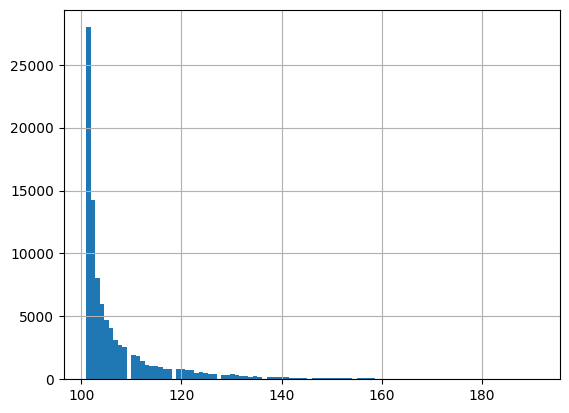

In [62]:
# Найдем кол-во дней от прекращения транзакций до времени отчета
tran_feats['days_last_tran'].hist(bins=100)

In [63]:
train_full = tran_feats.merge(train, on='user_id', how='left')
train_full['td'] = -1 * (train_full['days_last_tran'] - train_full['time']) / train_full['days_last_tran']

array([[<Axes: title={'center': 'days_last_tran'}>,
        <Axes: title={'center': 'time'}>]], dtype=object)

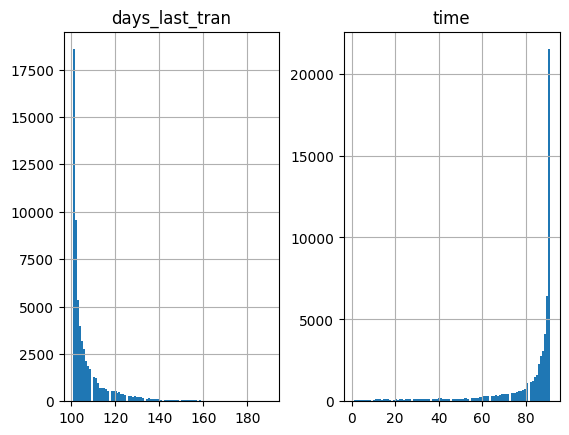

In [64]:
train_full[~train_full.target.isna()][['days_last_tran', 'time']].hist(bins=100)

In [65]:
train_full[~train_full.target.isna()][['days_last_tran', 'time', 'td']]

,days_last_tran,time,td
0,108,77.0,-0.287037
2,114,86.0,-0.245614
3,104,89.0,-0.144231
4,103,57.0,-0.446602
5,102,84.0,-0.176471
...,...,...,...
95992,102,91.0,-0.107843
95995,142,75.0,-0.471831
95997,122,91.0,-0.254098
95998,105,29.0,-0.723810


82.28631648741363
43.248496381407044
2.366905809708739


,user_id,last,count,logsumabs_0,logsumabs_1,logsumabs_2,logsumabs_3,report_dt,report,days_last_tran,target,time,td,mod_time
3,37,2022-08-17 09:52:33,315,0.000000,12.775178,0.0,0.0,2022-11-30 03:00:00,5,104,0.0,89.0,-0.144231,88.0
5,42,2023-03-19 19:49:22,59,0.000000,11.806563,0.0,0.0,2023-06-30 03:00:00,12,102,0.0,84.0,-0.176471,90.0
6,46,2023-02-18 18:32:10,369,0.000000,12.576277,0.0,0.0,2023-05-31 03:00:00,11,101,0.0,91.0,-0.099010,91.0
7,49,2022-04-19 16:12:15,319,0.000000,13.454894,0.0,0.0,2022-07-31 03:00:00,1,102,0.0,91.0,-0.107843,90.0
8,50,2022-04-14 15:50:08,19,14.983899,9.561899,0.0,0.0,2022-07-31 03:00:00,1,107,0.0,88.0,-0.177570,85.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95981,560758,2023-03-17 09:51:02,253,0.000000,11.258862,0.0,0.0,2023-06-30 03:00:00,12,104,0.0,88.0,-0.153846,88.0
95983,561018,2023-03-20 13:00:57,415,0.000000,12.304843,0.0,0.0,2023-06-30 03:00:00,12,101,1.0,81.0,-0.198020,91.0
95989,561417,2023-03-10 20:48:00,201,0.000000,13.606960,0.0,0.0,2023-06-30 03:00:00,12,111,0.0,91.0,-0.180180,81.0
95992,561824,2023-03-19 17:10:45,148,0.000000,11.272241,0.0,0.0,2023-06-30 03:00:00,12,102,0.0,91.0,-0.107843,90.0


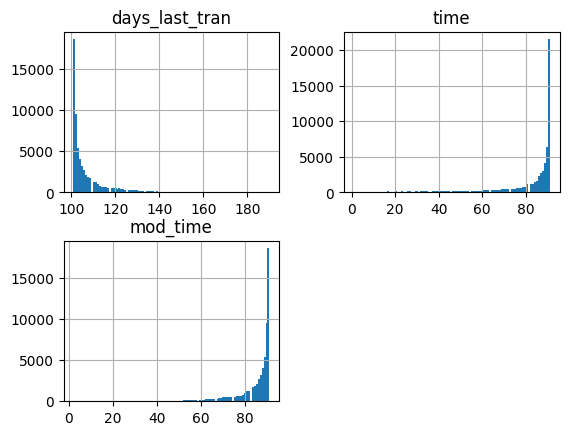

In [66]:
tmp0 = train_full[~train_full.target.isna()].copy()

# tmp.days_last_tran.min(), tmp.days_last_tran.max() # 101, 191
# tmp['time'].min(), tmp['time'].max() # 1, 91

def mod_time(x):
    mid = (101 + 191) / 2
    delta = mid - x
    new_x = (x + 2 * delta) - 100
    return new_x
    
tmp0['mod_time'] = tmp0['days_last_tran'].apply(lambda x: mod_time(x))
tmp0[['days_last_tran', 'time', 'mod_time']].hist(bins=100)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(mean_absolute_percentage_error(tmp0['time'], tmp0['days_last_tran']))
print(mean_absolute_percentage_error(tmp0['time'], tmp0['mod_time']))
print(mean_absolute_percentage_error(tmp0[abs(tmp0.td > -0.2)]['time'], tmp0[abs(tmp0.td > -0.2)]['mod_time']))
tmp0[tmp0.td > -0.2]

In [67]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

tmp = train_full[~train_full.target.isna()].copy()

bins = [el*100 for el in range(0, 6000)]
labels = [el*100 for el in range(1, 6000)]
tmp['bins1'] = pd.cut(tmp['user_id'], bins=bins, labels=labels)
mults1 = tmp.groupby(['bins1'], as_index=False)[['td']].mean().rename(columns={'td': 'mult1'})
tmp = tmp.merge(mults1, how='left', on='bins1')
tmp['pred_time1'] = tmp['days_last_tran'] * tmp['mult1'] + tmp['days_last_tran']
print(mean_absolute_percentage_error(tmp['time'], tmp['days_last_tran']))
print(mean_absolute_percentage_error(tmp['time'], tmp['pred_time1']))

mults2 = tmp.groupby(['report'], as_index=False)[['td']].mean().rename(columns={'td': 'mult2'})
tmp = tmp.merge(mults2, how='left', on='report')
tmp['pred_time2'] = tmp['days_last_tran'] * tmp['mult2'] + tmp['days_last_tran']
print(mean_absolute_percentage_error(tmp['time'], tmp['days_last_tran']))
print(mean_absolute_percentage_error(tmp['time'], tmp['pred_time2']))

bins = [el*10 for el in range(0, 300)]
labels = [el*10 for el in range(1, 300)]
tmp['bins3'] = pd.cut(tmp['count'], bins=bins, labels=labels)
mults3 = tmp.groupby(['bins3'], as_index=False)[['td']].mean().rename(columns={'td': 'mult3'})
tmp = tmp.merge(mults3, how='left', on='bins3')
tmp['pred_time3'] = tmp['days_last_tran'] * tmp['mult3'] + tmp['days_last_tran']
print(mean_absolute_percentage_error(tmp['time'], tmp['days_last_tran']))
print(mean_absolute_percentage_error(tmp['time'], tmp['pred_time3']))

bins = [el*10 for el in range(0, 30)]
labels = [el*10 for el in range(1, 30)]
tmp['bins4'] = pd.cut(tmp['days_last_tran'], bins=bins, labels=labels)
mults4 = tmp.groupby(['bins4'], as_index=False)[['td']].mean().rename(columns={'td': 'mult4'})
tmp = tmp.merge(mults4, how='left', on='bins4')
tmp['pred_time4'] = tmp['days_last_tran'] * tmp['mult4'] + tmp['days_last_tran']
print(mean_absolute_percentage_error(tmp['time'], tmp['days_last_tran']))
print(mean_absolute_percentage_error(tmp['time'], tmp['pred_time4']))

tmp['avg_mult'] = tmp[['mult1', 'mult3', 'mult4']].mean(axis=1)
tmp['pred_time_avg'] = tmp['days_last_tran'] * tmp['avg_mult'] + tmp['days_last_tran']
print(mean_absolute_percentage_error(tmp['time'], tmp['days_last_tran']))
print(mean_absolute_percentage_error(tmp['time'], tmp['pred_time_avg']))

82.28631648741363
48.73308174682239
82.28631648741363
53.72049941493461
82.28631648741363
49.94288702934951
82.28631648741363
45.4041647276692
82.28631648741363
46.99151699566141


In [68]:
bins = [el*100 for el in range(0, 6000)]
labels = [el*100 for el in range(1, 6000)]
tran_feats['bins1'] = pd.cut(tran_feats['user_id'], bins=bins, labels=labels)
tran_feats = tran_feats.merge(mults1, how='left', on='bins1')

tran_feats = tran_feats.merge(mults2, how='left', on='report')

bins = [el*10 for el in range(0, 300)]
labels = [el*10 for el in range(1, 300)]
tran_feats['bins3'] = pd.cut(tran_feats['count'], bins=bins, labels=labels)
tran_feats = tran_feats.merge(mults3, how='left', on='bins3')

bins = [el*10 for el in range(0, 30)]
labels = [el*10 for el in range(1, 30)]
tran_feats['bins4'] = pd.cut(tran_feats['days_last_tran'], bins=bins, labels=labels)
tran_feats = tran_feats.merge(mults4, how='left', on='bins4')

tran_feats.loc[tran_feats.mult1.isna(), 'mult1'] = tran_feats.mult1.mean()
tran_feats.loc[tran_feats.mult3.isna(), 'mult3'] = tran_feats.mult3.mean()
tran_feats.loc[tran_feats.mult4.isna(), 'mult4'] = tran_feats.mult4.mean()

tran_feats['avg_mult'] = tran_feats[['mult1', 'mult3', 'mult4']].mean(axis=1)
tran_feats['pred_time_avg'] = tran_feats['days_last_tran'] * tran_feats['avg_mult'] + tran_feats['days_last_tran']

In [69]:
train_full = tran_feats.merge(train, on='user_id', how='left')
feats = ['count', 'logsumabs_0', 'logsumabs_1',
         'days_last_tran', 'bins1',
         'mult1', 'mult2', 'bins3', 'mult3']
X = train_full[~train_full.target.isna()][feats]
y = train_full[~train_full.target.isna()]['time']

from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, y)

print(reg.score(X,y))
print(mean_absolute_percentage_error(y, reg.predict(X)))

tran_feats['pred_time_lr'] = reg.predict(train_full[feats])

0.17710929673800158
40.8654784494443


In [70]:
tmp2 = tran_feats.loc[tran_feats.user_id.isin(train.user_id)]
print(mean_absolute_percentage_error(tmp0['time'], (tmp0['mod_time'] + tmp2['pred_time_lr'])/2))

41.50159202460351


In [71]:
duplicate_cols = ['report', 'employee_count_nm', 'bankemplstatus', 'customer_age', 'report_dt']
cols_for_removing = ['last', 'count',
                     'bins1', 'mult1', 'mult2', 'bins3', 'mult3', 'days_last_tran',
                     'bins4', 'mult4', 'avg_mult', 'pred_time_avg', 'pred_time_lr']
main_3 = tran_feats[[el for el in tran_feats.columns if el not in cols_for_removing + duplicate_cols]].copy()
main_3_cat_cols = []
main_3_num_cols = []
for col in main_3.columns:
    if col not in ['user_id', 'target']:
        if main_3[col].nunique() < 90:
            main_3_cat_cols.append(col)
        else:
            main_3_num_cols.append(col)
main_3

,user_id,logsumabs_0,logsumabs_1,logsumabs_2,logsumabs_3
0,3,0.000000,12.789712,0.0,0.0
1,9,0.000000,12.686752,0.0,0.0
2,13,12.462834,12.825245,0.0,0.0
3,37,0.000000,12.775178,0.0,0.0
4,41,0.000000,11.595303,0.0,0.0
...,...,...,...,...,...
95995,562043,0.000000,10.294896,0.0,0.0
95996,562205,0.000000,10.701664,0.0,0.0
95997,562312,0.000000,9.827568,0.0,0.0
95998,562721,0.000000,12.357880,0.0,0.0


In [72]:
main_3_cat_cols, main_3_num_cols

([], ['logsumabs_0', 'logsumabs_1', 'logsumabs_2', 'logsumabs_3'])

#### Features 4

Бейзлайн 3

In [73]:
clients = pd.read_csv('/kaggle/input/ods-churn-24/clients.csv')
report_dates = pd.read_csv('/kaggle/input/ods-churn-24/report_dates.csv', parse_dates=['report_dt'])
transactions = pd.read_csv('/kaggle/input/ods-churn-24/transactions.csv', parse_dates=['transaction_dttm'])
currency_rk = pd.read_csv('/kaggle/input/ods-churn-24/currency_rk.csv')
currency_mult = pd.DataFrame({'currency_rk': [0,1,2,3], 'mult':[24,1,100,90]})
mcc_codes = pd.read_csv('/kaggle/input/ods-churn-24/mcc_codes.csv')
sample_submit_naive = pd.read_csv('/kaggle/input/ods-churn-24/sample_submit_naive.csv')
train = pd.read_csv('/kaggle/input/ods-churn-24/train.csv')

# transactions = transactions.merge(currency_mult, how='left')
# transactions.transaction_amt = transactions.transaction_amt * transactions.mult
# transactions.drop(columns=['mult'], inplace=True)


# Объединим всех юзеров в 1 датафрейм, для создания фичей
sample = sample_submit_naive.copy().drop('predict', axis=1)
sample['target'] = -1
main = pd.concat([train, sample])

transactions = transactions.sort_values('transaction_dttm').reset_index(drop=True)

In [74]:
# Добавим информацию о клиенте, а также закодируем employee_count_nm

main = main.merge(clients, how='left', on='user_id')
main['employee_count_nm'] = LabelEncoder().fit_transform(main['employee_count_nm'].fillna('unknown'))

In [75]:
# Для категорий, которые встречались больше 10 раз агрегируем информацию о транзакциях по пользователю и коду MCC

# good_codes = transactions['mcc_code'].value_counts()
# good_codes = good_codes[good_codes >= 10]

good_codes = transactions.groupby(['mcc_code'], as_index=False)[['user_id']].count()
good_codes = good_codes[good_codes.user_id >= 50].mcc_code.values

mcc_info = transactions[transactions.mcc_code.isin(good_codes)].pivot_table(
    index = 'user_id',
    values=['transaction_amt'],
    columns=['mcc_code'],
    aggfunc=['count', 'median', 'sum']
).fillna(0)
mcc_info.columns = ['main_' + '_'.join(map(str, x)) for x in mcc_info.columns]

count_cols = [x for x in mcc_info.columns if 'count' in x]
mcc_info['sum'] = mcc_info[count_cols].sum(axis=1)
for col in count_cols:
    mcc_info[f'{col}_norm'] = mcc_info[col] / mcc_info['sum']
mcc_info.drop('sum', axis=1, inplace=True)

main = main.merge(mcc_info, how='left', left_on='user_id', right_index=True)

In [76]:
# pivot_table по валютам со сбором базовой информации

currency_pivot = transactions.pivot_table(
    index='user_id',
    columns='currency_rk',
    values='transaction_amt',
    aggfunc=['min', 'max', 'median', 'count', 'std']
).fillna(0)
currency_pivot.columns = [f'currency_{x[0]}_{x[1]}' for x in currency_pivot.columns]

# Сборка нормированных значений о том в каких валютах были транзации у клиента
currency_pivot['sum'] = currency_pivot[[f'currency_count_{x}' for x in range(4)]].sum(axis=1)
for x in range(4):
    currency_pivot[f'currency_count_{x}_norm'] = currency_pivot[f'currency_count_{x}'] / currency_pivot['sum']
currency_pivot.drop('sum', axis=1, inplace=True)

main = main.merge(currency_pivot, how='left', left_on='user_id', right_index=True)

In [77]:
# Сбор информации о транзакциях в каждой валюте за последние 30 дней, а также за весь промежуток

df_more = transactions.merge(clients[['user_id', 'report']], how='left', on='user_id')
df_more = df_more.merge(report_dates, how='left', on='report')
df_more['days_to_report'] = (df_more['report_dt'] - df_more['transaction_dttm']).dt.days


for day_diff in [30, 1000]:

    # Информация о размерах транзакций в различных валютах
    currency_pivot = df_more[df_more['days_to_report'] < day_diff + 100].pivot_table(
        index='user_id',
        columns='currency_rk',
        values='transaction_amt',
        aggfunc=['sum', 'mean', 'median', 'count']
    ).fillna(0)
    currency_pivot.columns = [f'currency_daydiff_{day_diff}_{x[0]}_{x[1]}' for x in currency_pivot.columns]

    currency_pivot['sum'] = currency_pivot[[x for x in currency_pivot.columns if 'count' in x]].sum(axis=1)
    for x in range(4):
        currency_pivot[f'currency_daydiff_{day_diff}_count_{x}_norm'] = currency_pivot[f'currency_daydiff_{day_diff}_count_{x}'] / currency_pivot['sum']
    currency_pivot.drop('sum', axis=1, inplace=True)

    main = main.merge(currency_pivot, how='left', left_on='user_id', right_index=True)


    general_trans_info = df_more[df_more['days_to_report'] < day_diff + 100].groupby('user_id')['transaction_amt'].agg(['sum', 'count', 'median'])
    general_trans_info[['sum', 'count']] = general_trans_info[['sum', 'count']].fillna(0)
    general_trans_info.columns = [f'general_trans_info_{day_diff}_{x}' for x in general_trans_info]
    main = main.merge(general_trans_info, how='left', left_on='user_id', right_index=True)

    general_trans_info = df_more[(df_more['days_to_report']<day_diff + 100)&(df_more['transaction_amt']>0)].groupby('user_id')['transaction_amt'].agg(['sum', 'count', 'median'])
    general_trans_info[['sum', 'count']] = general_trans_info[['sum', 'count']].fillna(0)
    general_trans_info.columns = [f'positive_general_trans_info_{day_diff}_{x}' for x in general_trans_info]
    main = main.merge(general_trans_info, how='left', left_on='user_id', right_index=True)

    general_trans_info = df_more[(df_more['days_to_report']<day_diff + 100)&(df_more['transaction_amt']<0)].groupby('user_id')['transaction_amt'].agg(['sum', 'count', 'median'])
    general_trans_info[['sum', 'count']] = general_trans_info[['sum', 'count']].fillna(0)
    general_trans_info.columns = [f'negative_general_trans_info_{day_diff}_{x}' for x in general_trans_info]
    main = main.merge(general_trans_info, how='left', left_on='user_id', right_index=True)


# Анализируем кол-во транзакций в последние n дней / кол-во транзакций до последних n дней
for x in [5, 30]:
    prev = df_more[df_more['days_to_report'] > x + 100].groupby('user_id')['report'].agg(['count']).reset_index().rename({'count': f'num_transaction_before_{x}_days'}, axis=1)
    last = df_more[df_more['days_to_report'] <= x + 100].groupby('user_id')['report'].agg(['count']).reset_index().rename({'count': f'num_transaction_last_{x}_days'}, axis=1)

    main = main.merge(prev, how='left', on='user_id')
    main = main.merge(last, how='left', on='user_id')
    main[f'num_transaction_last_{x}_days'].fillna(0, inplace=True)
    main[f'num_transaction_before_{x}_days'].fillna(0, inplace=True)
    main[f'percent_last_{x}'] = main[f'num_transaction_last_{x}_days'] / main[f'num_transaction_before_{x}_days']
    
# percent_last_30 хорошо себя показывает, поэтому делаем аналоги

for x in [10, 15, 20, 25, 45, 60, 90, 120, 150, 180]:
    prev = df_more[df_more['days_to_report'] > x + 100].groupby('user_id')['report'].agg(['count']).reset_index().rename({'count': f'num_transaction_before_{x}_days'}, axis=1)
    last = df_more[df_more['days_to_report'] <= x + 100].groupby('user_id')['report'].agg(['count']).reset_index().rename({'count': f'num_transaction_last_{x}_days'}, axis=1)

    main = main.merge(prev, how='left', on='user_id')
    main = main.merge(last, how='left', on='user_id')
    main[f'num_transaction_last_{x}_days'].fillna(0, inplace=True)
    main[f'num_transaction_before_{x}_days'].fillna(0, inplace=True)
    main[f'percent_last_{x}'] = main[f'num_transaction_last_{x}_days'] / main[f'num_transaction_before_{x}_days']
    main.drop([f'num_transaction_last_{x}_days', f'num_transaction_before_{x}_days'], axis=1, inplace=True)
    
xs = [0, 15, 30, 45, 60, 90, 120, 150, 180]
for ind in range(6):
    prev = df_more[(df_more['days_to_report'] > xs[ind] + 100) & (df_more['days_to_report'] <= xs[ind+1] + 100)].groupby('user_id')['report'].agg(['count']).reset_index().rename({'count': f'num_transaction_before_{xs[ind]}_{xs[ind+1]}_days'}, axis=1)
    prev_prev = df_more[(df_more['days_to_report'] > xs[ind+1] + 100) & (df_more['days_to_report'] <= xs[ind+2] + 100)].groupby('user_id')['report'].agg(['count']).reset_index().rename({'count': f'num_transaction_before_before_{xs[ind+1]}_{xs[ind+2]}_days'}, axis=1)
    main = main.merge(prev, how='left', on='user_id')
    main = main.merge(prev_prev, how='left', on='user_id')
    main[f'num_transaction_before_{xs[ind]}_{xs[ind+1]}_days'].fillna(0, inplace=True)
    main[f'num_transaction_before_before_{xs[ind+1]}_{xs[ind+2]}_days'].fillna(0, inplace=True)
    main[f'percent_last_{xs[ind]}_{xs[ind+1]}'] = main[f'num_transaction_before_before_{xs[ind+1]}_{xs[ind+2]}_days'] / main[f'num_transaction_before_{xs[ind]}_{xs[ind+1]}_days']
    main.drop([f'num_transaction_before_{xs[ind]}_{xs[ind+1]}_days', f'num_transaction_before_before_{xs[ind+1]}_{xs[ind+2]}_days'], axis=1, inplace=True)

In [78]:
# Кол-во уникальных MCC кодов, валют, а также уникальных дней, в которые были транзакции
main = main.merge(df_more.groupby('user_id')['days_to_report'].nunique(), how='left', on='user_id').rename({'days_to_report': 'nunique_days'}, axis=1)
main = main.merge(df_more.groupby('user_id')['mcc_code'].nunique(), how='left', on='user_id').rename({'mcc_code': 'nunique_mcc_codes'}, axis=1)
main = main.merge(df_more.groupby('user_id')['currency_rk'].nunique(), how='left', on='user_id').rename({'currency_rk': 'nunique_currency'}, axis=1)

In [79]:
# Информация о количестве и размере транзакций в разрезе часов.

tmp = transactions.copy()
tmp['hour'] = tmp['transaction_dttm'].dt.hour
pivot_table = tmp.pivot_table(
    index='user_id',
    columns='hour',
    values='transaction_amt',
    aggfunc=['count', 'median']
).fillna(0)
pivot_table.columns = [f'hour_{x[0]}_{x[1]}' for x in pivot_table.columns]

count_cols = [x for x in pivot_table.columns if 'count' in x]
pivot_table['sum'] = pivot_table[count_cols].sum(axis=1)
for col in count_cols:
    pivot_table[f'{col}_norm'] = pivot_table[col] / pivot_table['sum']
pivot_table.drop('sum', axis=1, inplace=True)

main = main.merge(pivot_table, how='left', left_on='user_id', right_index=True)

In [80]:
# Фичи, основанные на временных отрезках

cur = transactions.groupby('user_id')['transaction_dttm'].agg(['min', 'max']).reset_index()
cur = cur.merge(clients[['user_id', 'report']], how='left', on='user_id')
cur = cur.merge(report_dates, how='left', on='report')

cur['min_diff_dttm'] = (cur['report_dt'] - cur['min']).dt.days
cur['days_to_report'] = (cur['report_dt'] - cur['max']).dt.days
cur['max_min_diff_dttm'] = cur['days_to_report'] - cur['min_diff_dttm']

main = main.merge(cur[['user_id', 'min_diff_dttm','days_to_report','max_min_diff_dttm']], how='left', on='user_id')


main['transaction_density'] = main['max_min_diff_dttm'] / main['general_trans_info_1000_count']
main['days_density'] = (main['max_min_diff_dttm'] + 1) / main['nunique_days']

In [81]:
# # Статистические фичи

# cur = main[main.target != -1]
# cur = cur.groupby(['customer_age', 'employee_count_nm'])['target'].agg(['mean']).reset_index().rename({'mean':'group_employee_age_mean'}, axis=1)
# main = main.merge(cur, how='left', on=['customer_age', 'employee_count_nm'])
# main.loc[main.target != -1, 'group_report_employee_age_mean'] = -1

# cur = main[main.target != -1]
# cur = cur.groupby(['report', 'customer_age'])['target'].agg(['mean']).reset_index().rename({'mean':'group_report_age_mean'}, axis=1)
# main = main.merge(cur, how='left', on=['report', 'customer_age'])
# main.loc[main.target != -1, 'group_report_age_mean'] = -1


# Смотрим на MCC код последних транзакций, берем средний средний таргет (есть небольшой лик:) )

# cur = transactions.merge(main[['user_id', 'target']], on='user_id', how='left').groupby('user_id').last().reset_index()
# last_transaction = cur[cur['target'] != -1].groupby('mcc_code')['target'].agg(['mean', 'count']).sort_values('mean').reset_index()
# last_transaction = last_transaction[last_transaction['count'] > 100]

# cur = cur[['user_id', 'mcc_code']].merge(last_transaction[['mcc_code', 'mean']], how='left', on='mcc_code').rename({'mean': 'mean_target_last_mcc_code'}, axis=1)
# main = main.merge(cur[['user_id', 'mean_target_last_mcc_code']], how='left', on='user_id')

In [82]:
cat_cols = ['customer_age', 'employee_count_nm', 'report']
main[cat_cols] = main[cat_cols].astype(str)

main = main.sort_values('user_id').reset_index(drop=True)

train = main[main.target != -1]
test = main[main.target == -1]

In [83]:
# Обучение модельки для того чтобы получить важные фичи

model = CatBoostClassifier(
    iterations = 1400,
    depth=5,
    learning_rate=0.03,
    
    eval_metric='AUC',
#     cat_features = cat_cols,
    thread_count=6,
    early_stopping_rounds=200,
)
# model.fit(train.drop(['user_id', 'target', 'time', 'group_employee_age_mean', 'group_report_age_mean'], axis=1), train['target'], verbose=100)
model.fit(train.drop(['user_id', 'target', 'time']+cat_cols, axis=1), train['target'], verbose=100)


df_imp = pd.DataFrame({
#     'name': train.drop(['user_id', 'target', 'time', 'group_employee_age_mean', 'group_report_age_mean'], axis=1).columns,
    'name': train.drop(['user_id', 'target', 'time']+cat_cols, axis=1).columns,
    'imp': model.get_feature_importance()
}).sort_values('imp', ascending=False)

display(df_imp) # Можно посмотреть на предварительный feature_importance()

df_imp = df_imp[df_imp['imp'] > 0.15] # Берем все фичи, у которых важность больше 0.3

# Добавляем статистические фичи, их нельзя было использовать для тренировки здесь, т.к. получился бы лик в данных
# good_cols = df_imp['name'].tolist() + ['group_employee_age_mean', 'group_report_age_mean']
good_cols = df_imp['name'].tolist()

TBB Warning: The number of workers is currently limited to 3. The request for 5 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



0:	total: 297ms	remaining: 6m 55s
100:	total: 21.8s	remaining: 4m 40s
200:	total: 43.8s	remaining: 4m 20s
300:	total: 1m 3s	remaining: 3m 53s
400:	total: 1m 22s	remaining: 3m 25s
500:	total: 1m 43s	remaining: 3m 5s
600:	total: 2m 1s	remaining: 2m 42s
700:	total: 2m 19s	remaining: 2m 19s
800:	total: 2m 38s	remaining: 1m 58s
900:	total: 2m 56s	remaining: 1m 37s
1000:	total: 3m 15s	remaining: 1m 17s
1100:	total: 3m 33s	remaining: 57.9s
1200:	total: 3m 51s	remaining: 38.4s
1300:	total: 4m 10s	remaining: 19.1s
1399:	total: 4m 28s	remaining: 0us


,name,imp
1054,currency_std_1,3.538122
1125,percent_last_10,2.331399
530,main_sum_transaction_amt_12,2.159617
1218,max_min_diff_dttm,2.154029
1115,positive_general_trans_info_1000_median,2.140940
...,...,...
496,main_median_transaction_amt_242,0.000000
926,main_count_transaction_amt_149_norm,0.000000
498,main_median_transaction_amt_246,0.000000
500,main_median_transaction_amt_251,0.000000


In [84]:
df_imp

,name,imp
1054,currency_std_1,3.538122
1125,percent_last_10,2.331399
530,main_sum_transaction_amt_12,2.159617
1218,max_min_diff_dttm,2.154029
1115,positive_general_trans_info_1000_median,2.140940
...,...,...
1158,hour_count_14,0.152782
1191,hour_median_23,0.152629
3,main_count_transaction_amt_2,0.152080
1182,hour_median_14,0.151283


In [85]:
new_main = main[['user_id']+good_cols].copy()

In [86]:
duplicate_cols = ['report', 'employee_count_nm', 'bankemplstatus', 'customer_age', 'report_dt']
cols_for_removing = ['last', 'count', 'target', 'time']
main_4 = new_main[[el for el in new_main.columns if el not in cols_for_removing + duplicate_cols]].copy()
main_4_cat_cols = []
main_4_num_cols = []
for col in main_4.columns:
    if col not in ['user_id', 'target', 'time']:
        if False:
            main_4_cat_cols.append(col)
        else:
            main_4_num_cols.append(col)
            
main_4.replace([np.inf, -np.inf], np.nan, inplace=True)
main_4.fillna(0, inplace=True)
main_4

,user_id,currency_std_1,percent_last_10,main_sum_transaction_amt_12,max_min_diff_dttm,positive_general_trans_info_1000_median,hour_median_3,hour_median_2,currency_daydiff_1000_mean_1,main_count_transaction_amt_28_norm,currency_daydiff_30_mean_1,negative_general_trans_info_1000_median,currency_daydiff_1000_sum_1,main_median_transaction_amt_1,currency_max_1,main_sum_transaction_amt_155,percent_last_5,currency_daydiff_30_sum_1,main_count_transaction_amt_0,main_median_transaction_amt_12,percent_last_30,percent_last_60,main_median_transaction_amt_0,transaction_density,main_count_transaction_amt_51,main_sum_transaction_amt_8,percent_last_45,negative_general_trans_info_1000_sum,percent_last_15,currency_min_1,main_count_transaction_amt_51_norm,general_trans_info_1000_sum,main_count_transaction_amt_0_norm,main_count_transaction_amt_12,percent_last_25,general_trans_info_1000_median,main_count_transaction_amt_3_norm,main_median_transaction_amt_7,main_count_transaction_amt_15_norm,percent_last_0_15,percent_last_30_45,main_count_transaction_amt_2_norm,main_sum_transaction_amt_0,nunique_mcc_codes,main_count_transaction_amt_155,main_count_transaction_amt_155_norm,currency_daydiff_30_median_1,main_median_transaction_amt_15,hour_count_5_norm,main_count_transaction_amt_9,positive_general_trans_info_1000_count,main_median_transaction_amt_51,min_diff_dttm,main_count_transaction_amt_26_norm,general_trans_info_30_sum,negative_general_trans_info_30_sum,days_density,main_median_transaction_amt_8,hour_median_15,main_median_transaction_amt_3,hour_median_4,main_sum_transaction_amt_51,currency_daydiff_1000_mean_0,main_count_transaction_amt_3,currency_daydiff_1000_count_1,currency_median_1,hour_median_12,main_count_transaction_amt_43_norm,hour_median_16,main_count_transaction_amt_45_norm,main_median_transaction_amt_155,main_median_transaction_amt_99,num_transaction_before_30_days,num_transaction_last_5_days,hour_median_8,percent_last_120,hour_median_10,percent_last_90,percent_last_20,main_count_transaction_amt_26,main_count_transaction_amt_30_norm,percent_last_45_60,negative_general_trans_info_30_median,main_count_transaction_amt_18,hour_median_17,num_transaction_before_5_days,main_sum_transaction_amt_15,hour_count_0_norm,main_median_transaction_amt_110,hour_count_0,currency_count_1,hour_count_15_norm,nunique_days,main_count_transaction_amt_12_norm,main_count_transaction_amt_94_norm,hour_count_21_norm,positive_general_trans_info_1000_sum,main_sum_transaction_amt_28,days_to_report,general_trans_info_30_median,hour_count_8,main_median_transaction_amt_28,hour_median_13,currency_daydiff_1000_median_1,main_count_transaction_amt_33_norm,main_sum_transaction_amt_9,hour_count_1_norm,currency_count_0,hour_count_12_norm,positive_general_trans_info_30_count,hour_count_9,hour_count_1,positive_general_trans_info_30_median,hour_median_21,hour_median_9,negative_general_trans_info_1000_count,main_count_transaction_amt_9_norm,currency_daydiff_1000_sum_0,main_count_transaction_amt_93_norm,percent_last_15_30,hour_count_2_norm,main_sum_transaction_amt_33,percent_last_60_90,main_count_transaction_amt_18_norm,hour_count_17_norm,currency_daydiff_30_count_2_norm,hour_count_7_norm,main_sum_transaction_amt_42,main_count_transaction_amt_20_norm,main_count_transaction_amt_10_norm,percent_last_90_120,main_count_transaction_amt_14,main_sum_transaction_amt_1,currency_min_0,percent_last_150,currency_daydiff_30_count_1,hour_median_0,hour_count_16_norm,hour_count_5,hour_count_14_norm,hour_count_23_norm,hour_count_12,main_count_transaction_amt_63_norm,main_count_transaction_amt_33,hour_count_14,hour_median_23,main_count_transaction_amt_2,hour_median_14,main_sum_transaction_amt_27
0,3,60860.880477,0.222222,0.000000,-106,5386.999023,0.000000,0.000000,1246.037876,0.000000,43931.625732,-9175.519287,13706.416641,0.000000,104011.960938,0.000000,0.000000,175726.502930,7.0,0.000000,0.571429,1.200000,5386.999023,-9.636364,0.0,0.000000,1.200000,-172401.813156,0.222222,-153866.890625,0.0,13706.416641

In [87]:
main_4_cat_cols, len(main_4_num_cols)

([], 148)

#### Features 5

Всякие доп фичи похожие на фичи с высокой важностью и доп идеи от ChatGPT

In [88]:
clients = pd.read_csv('/kaggle/input/ods-churn-24/clients.csv')
report_dates = pd.read_csv('/kaggle/input/ods-churn-24/report_dates.csv', parse_dates=['report_dt'])
transactions = pd.read_csv('/kaggle/input/ods-churn-24/transactions.csv', parse_dates=['transaction_dttm'])
currency_rk = pd.read_csv('/kaggle/input/ods-churn-24/currency_rk.csv')
currency_mult = pd.DataFrame({'currency_rk': [0,1,2,3], 'mult':[24,1,100,90]})
mcc_codes = pd.read_csv('/kaggle/input/ods-churn-24/mcc_codes.csv')
sample_submit_naive = pd.read_csv('/kaggle/input/ods-churn-24/sample_submit_naive.csv')
train = pd.read_csv('/kaggle/input/ods-churn-24/train.csv')

transactions = transactions.merge(currency_mult, how='left')
transactions.transaction_amt = transactions.transaction_amt * transactions.mult
transactions.drop(columns=['mult'], inplace=True)

clients = merge_by_concat(clients, report_dates, ['report'])
transactions = merge_by_concat(transactions, clients[['user_id','report_dt']], ['user_id'])

transactions['days_since_transaction'] = (transactions['report_dt'] - transactions['transaction_dttm']).dt.days

In [89]:
main = clients.copy()

xs = [0, 15, 30, 45, 60, 90]
for ind in range(4):
    sl1 = transactions[(transactions.days_since_transaction > xs[ind] + 100) &
                       (transactions.days_since_transaction <= xs[ind+1] + 100)].copy()
    sl2 = transactions[(transactions.days_since_transaction > xs[ind+1] + 100) &
                       (transactions.days_since_transaction <= xs[ind+2] + 100)].copy()
    gr1 = sl1.groupby('user_id', as_index=False)['transaction_amt'].agg(['count', 'sum', 'mean', 'median']).reset_index(drop=True).rename({'count': f'trans_amt_count_{xs[ind]}_{xs[ind+1]}', 'sum': f'trans_amt_sum_{xs[ind]}_{xs[ind+1]}', 'mean': f'trans_amt_mean_{xs[ind]}_{xs[ind+1]}', 'median': f'trans_amt_median_{xs[ind]}_{xs[ind+1]}'}, axis=1)
    gr2 = sl2.groupby('user_id', as_index=False)['transaction_amt'].agg(['count', 'sum', 'mean', 'median']).reset_index(drop=True).rename({'count': f'trans_amt_count_{xs[ind+1]}_{xs[ind+2]}', 'sum': f'trans_amt_sum_{xs[ind+1]}_{xs[ind+2]}', 'mean': f'trans_amt_mean_{xs[ind+1]}_{xs[ind+2]}', 'median': f'trans_amt_median_{xs[ind+1]}_{xs[ind+2]}'}, axis=1)
    prev_cols = main.columns
    main = main.merge(gr1, how='left')
    main = main.merge(gr2, how='left')
    new_cols = [el for el in main.columns if el not in prev_cols]
    main[new_cols] = main[new_cols].fillna(0)
    main[f'trans_amt_count_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'trans_amt_count_{xs[ind+1]}_{xs[ind+2]}'] / main[f'trans_amt_count_{xs[ind]}_{xs[ind+1]}']
    main[f'trans_amt_sum_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'trans_amt_sum_{xs[ind+1]}_{xs[ind+2]}'] / main[f'trans_amt_sum_{xs[ind]}_{xs[ind+1]}']
    main[f'trans_amt_mean_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'trans_amt_mean_{xs[ind+1]}_{xs[ind+2]}'] / main[f'trans_amt_mean_{xs[ind]}_{xs[ind+1]}']
    main[f'trans_amt_median_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'trans_amt_median_{xs[ind+1]}_{xs[ind+2]}'] / main[f'trans_amt_median_{xs[ind]}_{xs[ind+1]}']
    main.drop([f'trans_amt_count_{xs[ind+1]}_{xs[ind+2]}', f'trans_amt_sum_{xs[ind+1]}_{xs[ind+2]}', f'trans_amt_mean_{xs[ind+1]}_{xs[ind+2]}', f'trans_amt_median_{xs[ind+1]}_{xs[ind+2]}'], axis=1, inplace=True)
    
    
    sl1 = transactions[(transactions.days_since_transaction > xs[ind] + 100) & (transactions.transaction_amt>0) &
                       (transactions.days_since_transaction <= xs[ind+1] + 100)].copy()
    sl2 = transactions[(transactions.days_since_transaction > xs[ind+1] + 100) & (transactions.transaction_amt>0) &
                       (transactions.days_since_transaction <= xs[ind+2] + 100)].copy()
    gr1 = sl1.groupby('user_id', as_index=False)['transaction_amt'].agg(['count', 'sum', 'mean', 'median']).reset_index(drop=True).rename({'count': f'trans_amt_pos_count_{xs[ind]}_{xs[ind+1]}', 'sum': f'trans_amt_pos_sum_{xs[ind]}_{xs[ind+1]}', 'mean': f'trans_amt_pos_mean_{xs[ind]}_{xs[ind+1]}', 'median': f'trans_amt_pos_median_{xs[ind]}_{xs[ind+1]}'}, axis=1)
    gr2 = sl2.groupby('user_id', as_index=False)['transaction_amt'].agg(['count', 'sum', 'mean', 'median']).reset_index(drop=True).rename({'count': f'trans_amt_pos_count_{xs[ind+1]}_{xs[ind+2]}', 'sum': f'trans_amt_pos_sum_{xs[ind+1]}_{xs[ind+2]}', 'mean': f'trans_amt_pos_mean_{xs[ind+1]}_{xs[ind+2]}', 'median': f'trans_amt_pos_median_{xs[ind+1]}_{xs[ind+2]}'}, axis=1)
    prev_cols = main.columns
    main = main.merge(gr1, how='left')
    main = main.merge(gr2, how='left')
    new_cols = [el for el in main.columns if el not in prev_cols]
    main[new_cols] = main[new_cols].fillna(0)
    main[f'trans_amt_pos_count_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'trans_amt_pos_count_{xs[ind+1]}_{xs[ind+2]}'] / main[f'trans_amt_pos_count_{xs[ind]}_{xs[ind+1]}']
    main[f'trans_amt_pos_sum_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'trans_amt_pos_sum_{xs[ind+1]}_{xs[ind+2]}'] / main[f'trans_amt_pos_sum_{xs[ind]}_{xs[ind+1]}']
    main[f'trans_amt_pos_mean_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'trans_amt_pos_mean_{xs[ind+1]}_{xs[ind+2]}'] / main[f'trans_amt_pos_mean_{xs[ind]}_{xs[ind+1]}']
    main[f'trans_amt_pos_median_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'trans_amt_pos_median_{xs[ind+1]}_{xs[ind+2]}'] / main[f'trans_amt_pos_median_{xs[ind]}_{xs[ind+1]}']
    main.drop([f'trans_amt_pos_count_{xs[ind+1]}_{xs[ind+2]}', f'trans_amt_pos_sum_{xs[ind+1]}_{xs[ind+2]}', f'trans_amt_pos_mean_{xs[ind+1]}_{xs[ind+2]}', f'trans_amt_pos_median_{xs[ind+1]}_{xs[ind+2]}'], axis=1, inplace=True)

    
    sl1 = transactions[(transactions.days_since_transaction > xs[ind] + 100) & (transactions.transaction_amt<0) &
                       (transactions.days_since_transaction <= xs[ind+1] + 100)].copy()
    sl2 = transactions[(transactions.days_since_transaction > xs[ind+1] + 100) & (transactions.transaction_amt<0) &
                       (transactions.days_since_transaction <= xs[ind+2] + 100)].copy()
    gr1 = sl1.groupby('user_id', as_index=False)['transaction_amt'].agg(['count', 'sum', 'mean', 'median']).reset_index(drop=True).rename({'count': f'trans_amt_neg_count_{xs[ind]}_{xs[ind+1]}', 'sum': f'trans_amt_neg_sum_{xs[ind]}_{xs[ind+1]}', 'mean': f'trans_amt_neg_mean_{xs[ind]}_{xs[ind+1]}', 'median': f'trans_amt_neg_median_{xs[ind]}_{xs[ind+1]}'}, axis=1)
    gr2 = sl2.groupby('user_id', as_index=False)['transaction_amt'].agg(['count', 'sum', 'mean', 'median']).reset_index(drop=True).rename({'count': f'trans_amt_neg_count_{xs[ind+1]}_{xs[ind+2]}', 'sum': f'trans_amt_neg_sum_{xs[ind+1]}_{xs[ind+2]}', 'mean': f'trans_amt_neg_mean_{xs[ind+1]}_{xs[ind+2]}', 'median': f'trans_amt_neg_median_{xs[ind+1]}_{xs[ind+2]}'}, axis=1)
    prev_cols = main.columns
    main = main.merge(gr1, how='left')
    main = main.merge(gr2, how='left')
    new_cols = [el for el in main.columns if el not in prev_cols]
    main[new_cols] = main[new_cols].fillna(0)
    main[f'trans_amt_neg_count_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'trans_amt_neg_count_{xs[ind+1]}_{xs[ind+2]}'] / main[f'trans_amt_neg_count_{xs[ind]}_{xs[ind+1]}']
    main[f'trans_amt_neg_sum_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'trans_amt_neg_sum_{xs[ind+1]}_{xs[ind+2]}'] / main[f'trans_amt_neg_sum_{xs[ind]}_{xs[ind+1]}']
    main[f'trans_amt_neg_mean_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'trans_amt_neg_mean_{xs[ind+1]}_{xs[ind+2]}'] / main[f'trans_amt_neg_mean_{xs[ind]}_{xs[ind+1]}']
    main[f'trans_amt_neg_median_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'trans_amt_neg_median_{xs[ind+1]}_{xs[ind+2]}'] / main[f'trans_amt_neg_median_{xs[ind]}_{xs[ind+1]}']
    main.drop([f'trans_amt_neg_count_{xs[ind+1]}_{xs[ind+2]}', f'trans_amt_neg_sum_{xs[ind+1]}_{xs[ind+2]}', f'trans_amt_neg_mean_{xs[ind+1]}_{xs[ind+2]}', f'trans_amt_neg_median_{xs[ind+1]}_{xs[ind+2]}'], axis=1, inplace=True)

In [90]:
# 3. Transaction density
transactions['next_transaction'] = transactions.groupby('user_id')['transaction_dttm'].shift(-1)
transactions['days_to_next_trans'] = (transactions['next_transaction'] - transactions['transaction_dttm']).dt.days
days_between_trans = transactions.groupby('user_id', as_index=False)['days_to_next_trans'].agg(['mean', 'median']).rename({'mean': 'days_between_trans_mean', 'median': 'days_between_trans_median'}, axis=1)
main = main.merge(days_between_trans, how='left')

xs = [0, 15, 30, 45, 60, 90]
for ind in range(5):
    sl = transactions[(transactions.days_since_transaction > xs[ind] + 100) &
                      (transactions.days_since_transaction <= xs[ind+1] + 100)].copy()
    days_between_trans = sl.groupby('user_id', as_index=False)['days_to_next_trans'].agg(['mean', 'median']).rename({'mean': f'days_between_trans_mean_{xs[ind]}_{xs[ind+1]}', 'median': f'days_between_trans_median_{xs[ind]}_{xs[ind+1]}'}, axis=1)
    main = main.merge(days_between_trans, how='left')

In [91]:
transactions['trans_day'] = transactions['transaction_dttm'].dt.date
unique_trans_days = transactions.groupby('user_id', as_index=False)['trans_day'].nunique().rename(columns={'trans_day': 'unique_trans_days'})
main = main.merge(unique_trans_days, how='left')

In [92]:
from sklearn.linear_model import LinearRegression

def calculate_trend(user_group):
    if len(user_group) < 2:  # Need at least two points to calculate a slope
        return 0
    lr = LinearRegression()
    X = np.array(range(len(user_group))).reshape(-1, 1)  # Time in days as X
    y = user_group['transaction_amt'].values
    lr.fit(X, y)
    return lr.coef_[0]  # Slope of the trend line

def calculate_trend2(user_group):
    if len(user_group) < 2:  # Need at least two points to calculate a slope
        return 0
    lr = LinearRegression()
    X = np.array(range(len(user_group))).reshape(-1, 1)  # Time in days as X
    y = user_group['days_to_next_trans'].values
    lr.fit(X, y)
    return lr.coef_[0]  # Slope of the trend line

transaction_trends_pos = transactions[transactions.transaction_amt>0].groupby('user_id').apply(calculate_trend).reset_index(name='trans_amount_trend_pos')
transaction_trends_neg = transactions[transactions.transaction_amt<0].groupby('user_id').apply(calculate_trend).reset_index(name='trans_amount_trend_neg')

transactions.days_to_next_trans = transactions.days_to_next_trans.fillna(0)

transaction_trends_dtnt = transactions.groupby('user_id').apply(calculate_trend2).reset_index(name='trans_amount_trend_dtnt')
main = main.merge(transaction_trends_pos, how='left')
main = main.merge(transaction_trends_neg, how='left')
main = main.merge(transaction_trends_dtnt, how='left')

In [93]:
cat_cols = ['customer_age', 'employee_count_nm', 'report', 'bankemplstatus', 'report_dt']
main = main[[el for el in main.columns if el not in cat_cols]]

main = main.sort_values('user_id').reset_index(drop=True)
main = main.merge(train, how='left')

train = main[~main.target.isna()]

# Обучение модельки для того чтобы получить важные фичи

model = CatBoostClassifier(
    iterations = 1400,
    depth=5,
    learning_rate=0.03,
    
    eval_metric='AUC',
#     cat_features = cat_cols,
    thread_count=6,
    early_stopping_rounds=200,
)
# model.fit(train.drop(['user_id', 'target', 'time', 'group_employee_age_mean', 'group_report_age_mean'], axis=1), train['target'], verbose=100)
model.fit(train.drop(['user_id', 'target', 'time'], axis=1), train['target'], verbose=100)


df_imp = pd.DataFrame({
#     'name': train.drop(['user_id', 'target', 'time', 'group_employee_age_mean', 'group_report_age_mean'], axis=1).columns,
    'name': train.drop(['user_id', 'target', 'time'], axis=1).columns,
    'imp': model.get_feature_importance()
}).sort_values('imp', ascending=False)

display(df_imp) # Можно посмотреть на предварительный feature_importance()

df_imp = df_imp[df_imp['imp'] > 0.15] # Берем все фичи, у которых важность больше 0.3

# Добавляем статистические фичи, их нельзя было использовать для тренировки здесь, т.к. получился бы лик в данных
# good_cols = df_imp['name'].tolist() + ['group_employee_age_mean', 'group_report_age_mean']
good_cols = df_imp['name'].tolist()

0:	total: 39.1ms	remaining: 54.7s
100:	total: 3.71s	remaining: 47.7s
200:	total: 7.19s	remaining: 42.9s
300:	total: 10.7s	remaining: 38.9s
400:	total: 14s	remaining: 34.8s
500:	total: 18s	remaining: 32.3s
600:	total: 21.3s	remaining: 28.3s
700:	total: 24.6s	remaining: 24.5s
800:	total: 27.8s	remaining: 20.8s
900:	total: 31.2s	remaining: 17.3s
1000:	total: 34.5s	remaining: 13.8s
1100:	total: 37.8s	remaining: 10.3s
1200:	total: 41.3s	remaining: 6.84s
1300:	total: 44.6s	remaining: 3.4s
1399:	total: 48.2s	remaining: 0us


,name,imp
96,days_between_trans_mean,3.935237
1,trans_amt_sum_0_15,3.406370
108,unique_trans_days,3.255513
2,trans_amt_mean_0_15,3.148756
17,trans_amt_neg_sum_0_15,2.738231
...,...,...
83,trans_amt_pos_median_45_60,0.146817
14,trans_amt_pos_mean_0_15_ratio,0.127102
12,trans_amt_pos_count_0_15_ratio,0.125923
13,trans_amt_pos_sum_0_15_ratio,0.097125


In [94]:
df_imp

,name,imp
96,days_between_trans_mean,3.935237
1,trans_amt_sum_0_15,3.406370
108,unique_trans_days,3.255513
2,trans_amt_mean_0_15,3.148756
17,trans_amt_neg_sum_0_15,2.738231
...,...,...
82,trans_amt_pos_mean_45_60,0.209441
63,trans_amt_pos_median_30_45_ratio,0.203007
62,trans_amt_pos_mean_30_45_ratio,0.189797
24,trans_amt_count_15_30,0.172839


In [95]:
main = main[['user_id']+good_cols]

In [96]:
main.replace([np.inf, -np.inf], np.nan, inplace=True)
main.fillna(0, inplace=True)

cols_for_removing = []
duplicate_cols = ['report', 'employee_count_nm', 'bankemplstatus', 'customer_age', 'report_dt']
main_5 = main[[el for el in main.columns if el not in cols_for_removing + duplicate_cols]].copy()
main_5_cat_cols = []
main_5_num_cols = []
for col in main_5.columns:
    if col not in ['user_id', 'target', 'report_dt']:
        if False:
            main_5_cat_cols.append(col)
        else:
            main_5_num_cols.append(col)
main_5

,user_id,days_between_trans_mean,trans_amt_sum_0_15,unique_trans_days,trans_amt_mean_0_15,trans_amt_neg_sum_0_15,trans_amt_pos_median_0_15,trans_amount_trend_pos,trans_amt_pos_sum_0_15,trans_amt_neg_median_0_15,trans_amt_pos_mean_0_15,trans_amt_mean_45_60,trans_amt_neg_mean_45_60,trans_amt_pos_sum_30_45,trans_amt_sum_15_30,trans_amount_trend_dtnt,trans_amt_sum_45_60_ratio,trans_amt_mean_30_45,days_between_trans_mean_0_15,trans_amount_trend_neg,trans_amt_median_45_60,trans_amt_median_0_15,trans_amt_sum_30_45,trans_amt_neg_median_45_60_ratio,days_between_trans_mean_60_90,trans_amt_pos_mean_30_45,trans_amt_neg_mean_0_15,days_between_trans_median_30_45,trans_amt_neg_count_0_15,trans_amt_neg_median_15_30,trans_amt_median_30_45,trans_amt_neg_median_45_60,trans_amt_mean_45_60_ratio,trans_amt_pos_median_30_45,days_between_trans_median,trans_amt_neg_mean_15_30,trans_amt_median_15_30,trans_amt_neg_sum_30_45_ratio,trans_amt_neg_sum_15_30,trans_amt_neg_median_15_30_ratio,trans_amt_mean_15_30,trans_amt_count_45_60_ratio,days_between_trans_mean_15_30,trans_amt_neg_count_15_30_ratio,trans_amt_count_0_15,trans_amt_neg_mean_30_45,trans_amt_neg_sum_45_60,trans_amt_neg_mean_45_60_ratio,trans_amt_pos_count_15_30,trans_amt_median_30_45_ratio,days_between_trans_median_60_90,days_between_trans_mean_30_45,trans_amt_neg_sum_0_15_ratio,trans_amt_neg_sum_30_45,trans_amt_neg_median_0_15_ratio,trans_amt_count_0_15_ratio,trans_amt_median_15_30_ratio,trans_amt_pos_count_45_60,trans_amt_median_45_60_ratio,trans_amt_sum_0_15_ratio,trans_amt_neg_count_45_60_ratio,trans_amt_neg_mean_30_45_ratio,trans_amt_sum_15_30_ratio,trans_amt_neg_median_30_45,trans_amt_pos_median_15_30,trans_amt_count_15_30_ratio,trans_amt_pos_count_0_15,days_between_trans_median_45_60,days_between_trans_mean_45_60,trans_amt_sum_30_45_ratio,trans_amt_median_0_15_ratio,trans_amt_neg_sum_45_60_ratio,trans_amt_mean_0_15_ratio,trans_amt_neg_count_30_45_ratio,trans_amt_sum_45_60,trans_amt_mean_15_30_ratio,days_between_trans_median_15_30,trans_amt_pos_sum_45_60_ratio,trans_amt_neg_count_45_60,trans_amt_pos_mean_15_30,trans_amt_neg_mean_0_15_ratio,trans_amt_pos_mean_45_60_ratio,trans_amt_mean_30_45_ratio,trans_amt_neg_count_0_15_ratio,trans_amt_count_30_45_ratio,trans_amt_pos_count_30_45,trans_amt_pos_count_15_30_ratio,trans_amt_neg_median_30_45_ratio,trans_amt_neg_sum_15_30_ratio,trans_amt_neg_count_15_30,trans_amt_pos_median_15_30_ratio,trans_amt_pos_sum_15_30_ratio,trans_amt_neg_count_30_45,days_between_trans_median_0_15,trans_amt_pos_median_45_60_ratio,trans_amt_pos_mean_15_30_ratio,trans_amt_count_45_60,trans_amt_pos_sum_45_60,trans_amt_pos_count_45_60_ratio,trans_amt_pos_sum_15_30,trans_amt_neg_mean_15_30_ratio,trans_amt_count_30_45,trans_amt_pos_mean_45_60,trans_amt_pos_median_30_45_ratio,trans_amt_pos_mean_30_45_ratio,trans_amt_count_15_30,trans_amt_pos_median_0_15_ratio
0,3,10.300000,109398.959961,8,54699.479980,0.000000,54699.479980,11772.628100,109398.959961,0.000000,54699.479980,0.000000,0.000000,5083.818176,66327.542969,-1.090909,0.000000,2541.909088,0.000000,-19554.260643,0.000000,54699.479980,5083.818176,0.000000,16.000000,2541.909088,0.000000,8.5,0.0,0.000000,2541.909088,0.000000,0.000000,2541.909088,7.0,0.000000,33163.771484,0.000000,0.000000,0.000000,33163.771484,0.000000,7.000000,0.000000,2.0,0.000000,0.000000,0.000000,2.0,0.000000,16.0,8.500000,0.000000,0.000000,0.000000,1.000000,0.076647,0.0,0.000000,0.606290,0.000000,0.000000,0.076647,0.000000,33163.771484,1.000000,2.0,0.0,0.000000,0.000000,0.606290,0.000000,0.606290,0.000000,0.000000,0.076647,7.0,0.000000,0.0,33163.771484,0.000000,0.000000,0.000000,0.000000,0.000000,2.0,1.0,0.000000,0.000000,0.0,0.076647,0.076647,0.0,0.0,0.000000,0.076647,0.0,0.000000,0.00,66327.542969,0.000000,2.0,0.000000,0.000000,0.000000,2.0,0.60629
1,9,1.719101,-7288.300293,54,-3644.150146,-7288.300293,0.000000,0.000000,0.000000,-3644.150146,0.000000,-12716.090650,-12716.090650,0.000000,-10872.021103,0.008618,0.139851,-1566.635498,0.000000,-75.063440,-5

In [97]:
main_5_cat_cols, main_5_num_cols

([],
 ['days_between_trans_mean',
  'trans_amt_sum_0_15',
  'unique_trans_days',
  'trans_amt_mean_0_15',
  'trans_amt_neg_sum_0_15',
  'trans_amt_pos_median_0_15',
  'trans_amount_trend_pos',
  'trans_amt_pos_sum_0_15',
  'trans_amt_neg_median_0_15',
  'trans_amt_pos_mean_0_15',
  'trans_amt_mean_45_60',
  'trans_amt_neg_mean_45_60',
  'trans_amt_pos_sum_30_45',
  'trans_amt_sum_15_30',
  'trans_amount_trend_dtnt',
  'trans_amt_sum_45_60_ratio',
  'trans_amt_mean_30_45',
  'days_between_trans_mean_0_15',
  'trans_amount_trend_neg',
  'trans_amt_median_45_60',
  'trans_amt_median_0_15',
  'trans_amt_sum_30_45',
  'trans_amt_neg_median_45_60_ratio',
  'days_between_trans_mean_60_90',
  'trans_amt_pos_mean_30_45',
  'trans_amt_neg_mean_0_15',
  'days_between_trans_median_30_45',
  'trans_amt_neg_count_0_15',
  'trans_amt_neg_median_15_30',
  'trans_amt_median_30_45',
  'trans_amt_neg_median_45_60',
  'trans_amt_mean_45_60_ratio',
  'trans_amt_pos_median_30_45',
  'days_between_trans_medi

#### Features 6

Всякие фичи от пакетов автогенерации фич

In [98]:
main_tsf = pd.read_csv('/kaggle/input/data-fusion-2024-churn-features-6/main_tsf.csv')
main_ft = pd.read_csv('/kaggle/input/data-fusion-2024-churn-features-6/main_ft.csv')

main_6 = clients[['user_id']].merge(main_tsf, how='left')
main_6 = main_6.merge(main_ft, how='left')

main_6.replace([np.inf, -np.inf], np.nan, inplace=True)
main_6.fillna(0, inplace=True)

cols_for_removing = []
duplicate_cols = ['report', 'employee_count_nm', 'bankemplstatus', 'customer_age', 'report_dt']
main_6 = main_6[[el for el in main_6.columns if el not in cols_for_removing + duplicate_cols]].copy()
main_6_cat_cols = []
main_6_num_cols = []
for col in main_6.columns:
    if col not in ['user_id', 'target', 'report_dt']:
        if main_6[col].nunique() < 25:
            main_6_cat_cols.append(col)
        else:
            main_6_num_cols.append(col)
main_6

,user_id,transaction_amt__maximum,"transaction_amt__fft_aggregated__aggtype_""kurtosis""",transaction_amt__number_crossing_m__m_0,"transaction_amt__fft_coefficient__attr_""abs""__coeff_0",transaction_amt__energy_ratio_by_chunks__num_segments_10__segment_focus_9,transaction_amt__quantile__q_0.7,transaction_amt__median,transaction_amt__quantile__q_0.9,"transaction_amt__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.4","transaction_amt__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.2",transaction_amt__index_mass_quantile__q_0.9,transaction_amt__quantile__q_0.8,transaction_amt__sum_values,transaction_amt__count_above__t_0,"transaction_amt__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.4",transaction_amt__absolute_maximum,transaction_amt__friedrich_coefficients__coeff_3__m_3__r_30,transaction_amt__quantile__q_0.6,"transaction_amt__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.2","transaction_amt__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""max""",transaction_amt__quantile__q_0.4,transaction_amt__quantile__q_0.3,transaction_amt__autocorrelation__lag_9,transaction_amt__ar_coefficient__coeff_0__k_10,"transaction_amt__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20)","transaction_amt__fft_coefficient__attr_""abs""__coeff_1","transaction_amt__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.6",transaction_amt__autocorrelation__lag_2,"transaction_amt__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""min""",transaction_amt__quantile__q_0.2,"transaction_amt__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.8","transaction_amt__fft_coefficient__attr_""imag""__coeff_2",transaction_amt__index_mass_quantile__q_0.8,transaction_amt__autocorrelation__lag_3,transaction_amt__autocorrelation__lag_4,"transaction_amt__change_quantiles__f_agg_""var""__isabs_True__qh_0.4__ql_0.2",transaction_amt__mean,transaction_amt__longest_strike_above_mean,transaction_amt__energy_ratio_by_chunks__num_segments_10__segment_focus_2,transaction_amt__last_location_of_maximum,"transaction_amt__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.2","transaction_amt__fft_coefficient__attr_""abs""__coeff_10",transaction_amt__energy_ratio_by_chunks__num_segments_10__segment_focus_6,"transaction_amt__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""min""",transaction_amt__fourier_entropy__bins_3,transaction_amt__approximate_entropy__m_2__r_0.5,"transaction_amt__fft_coefficient__attr_""angle""__coeff_14",transaction_amt__autocorrelation__lag_5,"transaction_amt__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.2",transaction_amt__range_count__max_1000000000000.0__min_0,transaction_amt__abs_energy,transaction_amt__benford_correlation,transaction_amt__variation_coefficient,"transaction_amt__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""mean""","transaction_amt__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.6","transaction_amt__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""max""",transaction_amt__partial_autocorrelation__lag_8,"transaction_amt__fft_coefficient__attr_""real""__coeff_24","transaction_amt__fft_coefficient__attr_""angle""__coeff_60",transaction_amt__partial_autocorrelation__lag_9,"transaction_amt__fft_coefficient__attr_""angle""__coeff_16",transaction_amt__energy_ratio_by_chunks__num_segments_10__segment_focus_3,"transaction_amt__change_quantiles__f_agg_""mean""__isabs_True__qh_0.4__ql_0.2","transaction_amt__change_quantiles__f_agg_""mean""__isabs_False__qh_0.6__ql_0.4",transaction_amt__approximate_entropy__m_2__r_0.1,"transaction_amt__fft_coefficient__attr_""angle""__coeff_73",transaction_amt__spkt_welch_density__coeff_2,transaction_amt__autocorrelation__lag_6,"transaction_amt__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.2","transaction_amt__fft_coefficient__attr_""abs""__coeff_31","transaction_amt__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.4","transaction_amt__fft_coefficient__attr_""

In [99]:
main_6_cat_cols, main_6_num_cols

(['NUM_UNIQUE(transactions.MONTH(transaction_dttm))',
  'PERCENTILE(NUM_UNIQUE(transactions.MONTH(transaction_dttm)))',
  'DIFF(NUM_UNIQUE(transactions.MONTH(transaction_dttm)))',
  'MODE(transactions.MONTH(transaction_dttm))',
  'DIFF(NUM_UNIQUE(transactions.WEEKDAY(transaction_dttm)))'],
 ['transaction_amt__maximum',
  'transaction_amt__fft_aggregated__aggtype_"kurtosis"',
  'transaction_amt__number_crossing_m__m_0',
  'transaction_amt__fft_coefficient__attr_"abs"__coeff_0',
  'transaction_amt__energy_ratio_by_chunks__num_segments_10__segment_focus_9',
  'transaction_amt__quantile__q_0.7',
  'transaction_amt__median',
  'transaction_amt__quantile__q_0.9',
  'transaction_amt__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4',
  'transaction_amt__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2',
  'transaction_amt__index_mass_quantile__q_0.9',
  'transaction_amt__quantile__q_0.8',
  'transaction_amt__sum_values',
  'transaction_amt__count_above__t_0',
  'transactio

#### Features 8
Перемножение топ фичей (кроме фичей автопакетов)

In [109]:
train = pd.read_csv('/kaggle/input/ods-churn-24/train.csv')

df = merge_by_concat(main_1, main_2, ['user_id'])
df = merge_by_concat(df, main_3, ['user_id'])
df = merge_by_concat(df, main_4, ['user_id'])
df = merge_by_concat(df, main_5, ['user_id'])
# df = merge_by_concat(df, main_6, ['user_id'])
all_cols = main_1_cat_cols + main_1_num_cols + main_2_cat_cols + main_2_num_cols + main_3_cat_cols + main_3_num_cols + main_4_cat_cols + main_4_num_cols + main_5_cat_cols + main_5_num_cols # + main_6_cat_cols + main_6_num_cols

df = merge_by_concat(df[['user_id'] + all_cols], train, ['user_id'])

cat_cols = []

for col in df.columns:
    if col not in ['user_id', 'target', 'time']:
        if df[col].nunique() < 15:
            cat_cols.append(col)
print(cat_cols)
            
df[cat_cols] = df[cat_cols].astype(str)
df = df.sort_values('user_id').reset_index(drop=True)
df.loc[df.target.isna(), 'target'] = -1
train = df[df.target != -1]
test = df[df.target == -1]

['report', 'employee_count_nm', 'bankemplstatus', 'customer_age', 'unique_currency_count', 'age_squared', 'employee_count_freq', 'customer_age_freq']


In [110]:
# Обучение модельки для того чтобы получить важные фичи

model = CatBoostClassifier(
    iterations = 1400,
    depth=5,
    learning_rate=0.03,

    eval_metric='AUC',
    cat_features = cat_cols,
    thread_count=6,
    early_stopping_rounds=200,
)
model.fit(train.drop(['user_id', 'target', 'time'], axis=1), train['target'], verbose=100)


df_imp_big = pd.DataFrame({
    'name': train.drop(['user_id', 'target', 'time'], axis=1).columns,
    'imp': model.get_feature_importance()
}).sort_values('imp', ascending=False)

df_imp = df_imp_big[df_imp_big['imp'] >= 0.85].copy() # 0.3

good_cols = df_imp['name'].tolist()

0:	total: 151ms	remaining: 3m 30s
100:	total: 15.6s	remaining: 3m 20s
200:	total: 30.4s	remaining: 3m 1s
300:	total: 45.8s	remaining: 2m 47s
400:	total: 1m	remaining: 2m 29s
500:	total: 1m 14s	remaining: 2m 13s
600:	total: 1m 27s	remaining: 1m 56s
700:	total: 1m 41s	remaining: 1m 41s
800:	total: 1m 56s	remaining: 1m 27s
900:	total: 2m 10s	remaining: 1m 12s
1000:	total: 2m 25s	remaining: 57.9s
1100:	total: 2m 39s	remaining: 43.3s
1200:	total: 2m 53s	remaining: 28.8s
1300:	total: 3m 7s	remaining: 14.3s
1399:	total: 3m 21s	remaining: 0us


In [111]:
new_features = []
for el1 in good_cols:
    for el2 in good_cols:
        if el1!=el2:
            new_feature = el1+'_mult_'+el2
            df[new_feature] = df[el1].astype(float) * df[el2].astype(float)
            new_features.append(new_feature)

In [112]:
main_8 = df[['user_id']+new_features].copy()

main_8.replace([np.inf, -np.inf], np.nan, inplace=True)
main_8.fillna(0, inplace=True)

cols_for_removing = []
duplicate_cols = ['report', 'employee_count_nm', 'bankemplstatus', 'customer_age', 'report_dt']
main_8 = main_8[[el for el in main_8.columns if el not in cols_for_removing + duplicate_cols]].copy()
main_8_cat_cols = []
main_8_num_cols = []
for col in main_8.columns:
    if col not in ['user_id', 'target', 'report_dt']:
        if main_8[col].nunique() < 100:
            main_8_cat_cols.append(col)
        else:
            main_8_num_cols.append(col)
main_8

,user_id,employee_count_nm_mult_min_day_trans_age,employee_count_nm_mult_hour_median_3,employee_count_nm_mult_currency_std_1,employee_count_nm_mult_trans_amount_age_interaction,employee_count_nm_mult_percent_last_10,employee_count_nm_mult_main_count_transaction_amt_28_norm,employee_count_nm_mult_report,employee_count_nm_mult_main_median_transaction_amt_0,employee_count_nm_mult_max_min_diff_dttm,employee_count_nm_mult_main_sum_transaction_amt_12,min_day_trans_age_mult_employee_count_nm,min_day_trans_age_mult_hour_median_3,min_day_trans_age_mult_currency_std_1,min_day_trans_age_mult_trans_amount_age_interaction,min_day_trans_age_mult_percent_last_10,min_day_trans_age_mult_main_count_transaction_amt_28_norm,min_day_trans_age_mult_report,min_day_trans_age_mult_main_median_transaction_amt_0,min_day_trans_age_mult_max_min_diff_dttm,min_day_trans_age_mult_main_sum_transaction_amt_12,hour_median_3_mult_employee_count_nm,hour_median_3_mult_min_day_trans_age,hour_median_3_mult_currency_std_1,hour_median_3_mult_trans_amount_age_interaction,hour_median_3_mult_percent_last_10,hour_median_3_mult_main_count_transaction_amt_28_norm,hour_median_3_mult_report,hour_median_3_mult_main_median_transaction_amt_0,hour_median_3_mult_max_min_diff_dttm,hour_median_3_mult_main_sum_transaction_amt_12,currency_std_1_mult_employee_count_nm,currency_std_1_mult_min_day_trans_age,currency_std_1_mult_hour_median_3,currency_std_1_mult_trans_amount_age_interaction,currency_std_1_mult_percent_last_10,currency_std_1_mult_main_count_transaction_amt_28_norm,currency_std_1_mult_report,currency_std_1_mult_main_median_transaction_amt_0,currency_std_1_mult_max_min_diff_dttm,currency_std_1_mult_main_sum_transaction_amt_12,trans_amount_age_interaction_mult_employee_count_nm,trans_amount_age_interaction_mult_min_day_trans_age,trans_amount_age_interaction_mult_hour_median_3,trans_amount_age_interaction_mult_currency_std_1,trans_amount_age_interaction_mult_percent_last_10,trans_amount_age_interaction_mult_main_count_transaction_amt_28_norm,trans_amount_age_interaction_mult_report,trans_amount_age_interaction_mult_main_median_transaction_amt_0,trans_amount_age_interaction_mult_max_min_diff_dttm,trans_amount_age_interaction_mult_main_sum_transaction_amt_12,percent_last_10_mult_employee_count_nm,percent_last_10_mult_min_day_trans_age,percent_last_10_mult_hour_median_3,percent_last_10_mult_currency_std_1,percent_last_10_mult_trans_amount_age_interaction,percent_last_10_mult_main_count_transaction_amt_28_norm,percent_last_10_mult_report,percent_last_10_mult_main_median_transaction_amt_0,percent_last_10_mult_max_min_diff_dttm,percent_last_10_mult_main_sum_transaction_amt_12,main_count_transaction_amt_28_norm_mult_employee_count_nm,main_count_transaction_amt_28_norm_mult_min_day_trans_age,main_count_transaction_amt_28_norm_mult_hour_median_3,main_count_transaction_amt_28_norm_mult_currency_std_1,main_count_transaction_amt_28_norm_mult_trans_amount_age_interaction,main_count_transaction_amt_28_norm_mult_percent_last_10,main_count_transaction_amt_28_norm_mult_report,main_count_transaction_amt_28_norm_mult_main_median_transaction_amt_0,main_count_transaction_amt_28_norm_mult_max_min_diff_dttm,main_count_transaction_amt_28_norm_mult_main_sum_transaction_amt_12,report_mult_employee_count_nm,report_mult_min_day_trans_age,report_mult_hour_median_3,report_mult_currency_std_1,report_mult_trans_amount_age_interaction,report_mult_percent_last_10,report_mult_main_count_transaction_amt_28_norm,report_mult_main_median_transaction_amt_0,report_mult_max_min_diff_dttm,report_mult_main_sum_transaction_amt_12,main_median_transaction_amt_0_mult_employee_count_nm,main_median_transaction_amt_0_mult_min_day_trans_age,main_median_transaction_amt_0_mult_hour_median_3,main_median_transaction_amt_0_mult_currency_std_1,main_median_transaction_amt_0_mult_trans_amount_age_interaction,main_median_transaction_amt_0_mult_percent_last_10,main_median_transaction_amt_0_mult_main_count_transaction_amt_28_norm,main_medi

In [113]:
main_8_cat_cols, main_8_num_cols

(['employee_count_nm_mult_report', 'report_mult_employee_count_nm'],
 ['employee_count_nm_mult_min_day_trans_age',
  'employee_count_nm_mult_hour_median_3',
  'employee_count_nm_mult_currency_std_1',
  'employee_count_nm_mult_trans_amount_age_interaction',
  'employee_count_nm_mult_percent_last_10',
  'employee_count_nm_mult_main_count_transaction_amt_28_norm',
  'employee_count_nm_mult_main_median_transaction_amt_0',
  'employee_count_nm_mult_max_min_diff_dttm',
  'employee_count_nm_mult_main_sum_transaction_amt_12',
  'min_day_trans_age_mult_employee_count_nm',
  'min_day_trans_age_mult_hour_median_3',
  'min_day_trans_age_mult_currency_std_1',
  'min_day_trans_age_mult_trans_amount_age_interaction',
  'min_day_trans_age_mult_percent_last_10',
  'min_day_trans_age_mult_main_count_transaction_amt_28_norm',
  'min_day_trans_age_mult_report',
  'min_day_trans_age_mult_main_median_transaction_amt_0',
  'min_day_trans_age_mult_max_min_diff_dttm',
  'min_day_trans_age_mult_main_sum_transac

#### Features 9
Фичи от 4 бейзлайна

In [114]:
clients = pd.read_csv('/kaggle/input/ods-churn-24/clients.csv').set_index("user_id")
clients.replace({'employee_count_nm':{'ОТ 101 ДО 500':4,'БОЛЕЕ 1001':6,'ОТ 501 ДО 1000':5,'ДО 10':0,
                                      'ОТ 11 ДО 50':2,'ОТ 51 ДО 100':3,'БОЛЕЕ 500':5,'ОТ 11 ДО 30':2,
                                      'ОТ 31 ДО 50':2}}, inplace=True)
report_dates = pd.read_csv('/kaggle/input/ods-churn-24/report_dates.csv', parse_dates=['report_dt']).set_index("report")
report_dates["report_dt"] = report_dates["report_dt"].astype('datetime64[ns]')
clients = clients.join(report_dates, on="report", how="left")
transactions = pd.read_csv('/kaggle/input/ods-churn-24/transactions.csv', parse_dates=['transaction_dttm'])
currency_rk = pd.read_csv('/kaggle/input/ods-churn-24/currency_rk.csv')
currency_mult = pd.DataFrame({'currency_rk': [0,1,2,3], 'mult':[24,1,100,90]})
mcc_codes = pd.read_csv('/kaggle/input/ods-churn-24/mcc_codes.csv')
sample_submit_naive = pd.read_csv('/kaggle/input/ods-churn-24/sample_submit_naive.csv')
train = pd.read_csv('/kaggle/input/ods-churn-24/train.csv').set_index("user_id")

In [115]:
def logsumabs(x):
    return (np.log(x.abs().sum()))
temp_tran = transactions.groupby(['user_id','currency_rk'])['transaction_amt'].agg([logsumabs])
temp_tran = temp_tran.unstack('currency_rk').fillna(0)
temp_tran.columns = ['logsumabs_0','logsumabs_1','logsumabs_2','logsumabs_3']

transactions['transaction_dttm'] = transactions['transaction_dttm'].astype('datetime64[ns]')
transactions['dweek'] = transactions['transaction_dttm'].dt.dayofweek# .day//8
transactions['date'] = transactions['transaction_dttm'].dt.date.astype('datetime64[ns]') # .day//8
transactions['sp'] = np.where( transactions['transaction_amt']>0,transactions['transaction_amt'],0)
transactions['sm'] = np.where( transactions['transaction_amt']<0,transactions['transaction_amt'],0)
transactions['ss'] = transactions['sp'] - transactions['sm'] 

transactions = transactions.join(clients ,on="user_id", how="left")
transactions['diff_days'] = (transactions['report_dt']-transactions['transaction_dttm']).dt.days
transactions['m'] = (transactions['report_dt'].dt.year-
                     transactions['transaction_dttm'].dt.year)*12+(transactions['report_dt'].dt.month-
                                                                   transactions['transaction_dttm'].dt.month)

count_trans = transactions.groupby(['user_id']
    ).agg({
        'transaction_amt':[
            "sum",
            "max",
            "min",
          #  "median",
            "count",
            #"last"
            ],
        "mcc_code":[
            #"last",
            "nunique"
            ],
        "currency_rk":[
            "min",
            "max"
            ],
        'date':[
            "min",
            "max",
            "count"
            ],
        "sp":"sum",
        "sm":"sum",
        "ss":"sum"
        })
count_trans.columns = count_trans.columns.map('_'.join).map(lambda x: "count_trans_"+str(x))
count_trans["count_trans_dates"]=(count_trans["count_trans_date_max"]-count_trans["count_trans_date_min"]).dt.days

# Сумма положительный транзакций
sum_trans_p = transactions[transactions['transaction_amt']>0].groupby(['user_id']
    ).agg({'transaction_amt':["count","mean"]})#.rename(columns={"transaction_amt":"sum_trans_p"})
sum_trans_p.columns = sum_trans_p.columns.map('_'.join).map(lambda x: "sump_"+str(x))

# Сумма отрицательных транзакций
sum_trans_m = transactions[transactions['transaction_amt']<0].groupby(['user_id']
    ).agg({'transaction_amt':["count","mean"]})#.rename(columns={"transaction_amt":"sum_trans_p"})
sum_trans_m.columns = sum_trans_m.columns.map('_'.join).map(lambda x: "summ_"+str(x))

msump = transactions.pivot_table(values="sp",                              
    index="user_id",
    columns="m",
    aggfunc='sum',
    fill_value=0,)
msump.columns = list( map(lambda x: "msump"+str(x), msump.columns ) )

msumm = transactions.pivot_table(values="sm",
    index="user_id",
    columns="m",
    aggfunc='sum',
    fill_value=0,)
msumm.columns = list( map(lambda x: "msumm"+str(x), msumm.columns ) )

msum = transactions.pivot_table(values="transaction_amt",
    index="user_id",
    columns=["m","currency_rk"],
    #aggfunc='sum',
    aggfunc='count',
    fill_value=0,)
msum.columns = list( map(lambda x: "msum"+str(x), msum.columns ) )

smc = transactions.pivot_table(values="sm",
    index="user_id",
    columns=["m","currency_rk"],
    aggfunc='count',
    fill_value=0,)
smc.columns = list( map(lambda x: "smc"+str(x), smc.columns ) )

spc = transactions.pivot_table(values="sp",
    index="user_id",
    columns="m",
    aggfunc='count',
    fill_value=0,)
spc.columns = list( map(lambda x: "spc"+str(x), spc.columns ) )

spdc = transactions.pivot_table(values="sp",
    index="user_id",
    columns="dweek",
    aggfunc='count',
    fill_value=0,)
spdc.columns = list( map(lambda x: "spdc"+str(x), spdc.columns ) )

spds = transactions.pivot_table(values="sp",
    index="user_id",
    columns="dweek",
    aggfunc='sum',
    fill_value=0,)
spds.columns = list( map(lambda x: "spds"+str(x), spds.columns ) )

smdc = transactions.pivot_table(values="sm",
    index="user_id",
    columns="dweek",
    aggfunc='count',
    fill_value=0,)
smdc.columns = list( map(lambda x: "smdc"+str(x), smdc.columns ) )

smds = transactions.pivot_table(values="sm",
    index="user_id",
    columns="dweek",
    aggfunc='sum',
    fill_value=0,)
smds.columns = list( map(lambda x: "smds"+str(x), smds.columns ) )

# Максимальная дата до отчета, по клиентам
max_day_trans = transactions.groupby(['user_id'])[['diff_days']].max().rename(columns={"diff_days":"max_day_trans"})
# Минимальная дата до отчета, по клиентам
min_day_trans = transactions.groupby(['user_id']
            )[['diff_days']].min().rename(columns={"diff_days":"min_day_trans"})

mcc_trans = transactions.pivot_table(    
    values="transaction_amt",
    index="user_id",
    columns="mcc_code",
    aggfunc="sum",
    #aggfunc=["sum","median"],
    #aggfunc=[logsumabs],
    fill_value=0,)
mcc_trans.columns = list( map(lambda x: "mcc"+str(x), mcc_trans.columns ) )

mcc_transc = transactions.pivot_table(    
    values="transaction_amt",
    index="user_id",
    columns="mcc_code",
    aggfunc='count',
    fill_value=0,)
mcc_transc.columns = list( map(lambda x: "mccc"+str(x), mcc_transc.columns ) )

mcc_transmc = transactions.pivot_table(    
    values="transaction_amt",
    index="user_id",
    #columns=["m","mcc_code"],
    columns=["mcc_code","m"],
    aggfunc=['sum','median'],
    #aggfunc='sum',
    fill_value=0,
)
mcc_transmc.columns = list( map(lambda x: "mccmc"+str(x), mcc_transmc.columns ) )

date_trans = transactions.groupby("user_id").agg({"date":"unique"}).explode("date").reset_index()#.sort(["user_id","date"])
date_trans["interval"]=date_trans.groupby("user_id")["date"].diff()
date_trans = date_trans.dropna() 
date_trans["interval"]=date_trans["interval"].dt.days
date_trans = date_trans.groupby("user_id").agg({"interval":["last","max"]})
date_trans.columns = list( map(lambda x: "date_"+str(x), date_trans.columns ) )

In [116]:
df = clients.join(
                count_trans, on="user_id", how="left"
                #).join(sum_trans, on="user_id", how="left"
                #).join(sum_trans_p, on="user_id", how="left"
                #).join(sum_trans_m, on="user_id", how="left"
                ).join(temp_tran, on="user_id", how="left"
                #).join(max_day_trans, on="user_id", how="left"
                #).join(min_day_trans, on="user_id", how="left"
                ).join(msump, on="user_id", how="left"
                ).join(msumm, on="user_id", how="left"
                ).join(msum, on="user_id", how="left"
                ).join(spc, on="user_id", how="left"
                ).join(smc, on="user_id", how="left"
                #).join(spdc, on="user_id", how="left"
                #).join(smdc, on="user_id", how="left"
                #).join(spds, on="user_id", how="left"
                #).join(smds, on="user_id", how="left"
                ).join(mcc_trans, on="user_id", how="left"
                ).join(mcc_transc, on="user_id", how="left"
                #).join(mcc_transmc, on="user_id", how="left"
                ).join(date_trans, on="user_id", how="left"
                       
#                 ).join(train, on="user_id", how="left"
                )

In [117]:
# train = pd.read_csv('/kaggle/input/ods-churn-24/train.csv')
# df = merge_by_concat(train, df, ['user_id'])

# cat_cols = []

# for col in df.columns:
#     if col not in ['user_id', 'target', 'time']:
#         if df[col].nunique() < 25:
#             cat_cols.append(col)
            
# df[cat_cols] = df[cat_cols].astype(str)
# df = df.sort_values('user_id').reset_index(drop=True)
# df.loc[df.target.isna(), 'target'] = -1
# train = df[df.target != -1]
# test = df[df.target == -1]

In [118]:
# # Обучение модельки для того чтобы получить важные фичи

# model = CatBoostClassifier(
#     iterations = 1400,
#     depth=4,
#     learning_rate=0.03,

#     eval_metric='AUC',
#     cat_features = cat_cols,
#     thread_count=6,
#     early_stopping_rounds=200,
#     task_type="GPU", devices='0:1'
# )
# model.fit(train.drop(['user_id', 'target', 'time'], axis=1), train['target'], verbose=100)


# df_imp_big = pd.DataFrame({
#     'name': train.drop(['user_id', 'target', 'time'], axis=1).columns,
#     'imp': model.get_feature_importance()
# }).sort_values('imp', ascending=False)

# df_imp = df_imp_big[df_imp_big['imp'] >= 0.85].copy() # 0.3

# good_cols = df_imp['name'].tolist()

In [119]:
good_cols = ['employee_count_nm', 'customer_age', 'count_trans_dates', 'msumm3', 'mccc0', 'msumm4', 'count_trans_transaction_amt_sum', 'count_trans_date_max', 'mcc155', 'mccc51', 'mcc0', 'mcc51', 'logsumabs_1', 'count_trans_ss_sum', "date_('interval', 'max')", 'mccc3', 'mcc8', 'count_trans_transaction_amt_max', 'mcc12', 'count_trans_sm_sum', 'count_trans_mcc_code_nunique', 'count_trans_transaction_amt_min', 'count_trans_transaction_amt_count', 'mccc155', 'count_trans_date_count']

df = df[good_cols]
# good_cols

In [120]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

duplicate_cols = ['report', 'employee_count_nm', 'bankemplstatus', 'customer_age', 'report_dt']
cols_for_removing = ['logsumabs_0', 'logsumabs_1', 'logsumabs_2', 'logsumabs_3']
main_9 = df[[el for el in df.columns if el not in cols_for_removing + duplicate_cols]].copy()
main_9_cat_cols = []
main_9_num_cols = []
for col in main_9.columns:
    if col not in ['user_id', 'target', 'time']:
        if main_9[col].nunique() < 25:
            main_9_cat_cols.append(col)
        else:
            main_9_num_cols.append(col)
main_9

,count_trans_dates,msumm3,mccc0,msumm4,count_trans_transaction_amt_sum,count_trans_date_max,mcc155,mccc51,mcc0,mcc51,count_trans_ss_sum,"date_('interval', 'max')",mccc3,mcc8,count_trans_transaction_amt_max,mcc12,count_trans_sm_sum,count_trans_mcc_code_nunique,count_trans_transaction_amt_min,count_trans_transaction_amt_count,mccc155,count_trans_date_count
user_id,,,,,,,,,,,,,,,,,,,,,,
3,106,0.000000,7,0.000000,13706.416641,2022-05-14,0.000000,0,186108.229797,0.0,358510.042953,30.0,2,0.000000,104011.960938,0.000000,-172401.813156,4,-153866.890625,11,0,11
9,181,-13289.485764,0,-104223.187939,-323434.666813,2022-04-19,0.000000,0,0.000000,0.0,323434.666813,22.0,5,-5204.533508,-45.579891,0.000000,-323434.666813,22,-90147.617188,90,0,90
13,168,-16394.193359,0,-27095.248047,-124717.379150,2022-09-07,0.000000,0,0.000000,0.0,382250.747803,21.0,14,0.000000,70322.828125,31293.108643,-253484.063477,4,-58740.300781,22,0,22
37,179,-32719.820328,2,-41364.700729,-331859.599463,2022-08-17,-2251.359375,0,10738.788574,0.0,353337.176611,7.0,28,-1031.058945,5487.140625,0.000000,-342598.388037,28,-35782.984375,315,1,315
41,153,-8045.445801,0,-17708.008820,-108586.614166,2022-04-18,0.000000,0,0.000000,0.0,108586.614166,31.0,6,0.000000,-290.766998,0.000000,-108586.614166,5,-16841.208984,16,0,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562043,124,0.000000,0,-142.056610,-29581.256115,2023-02-07,0.000000,0,0.000000,0.0,29581.256115,54.0,1,-870.556900,-40.769005,0.000000,-29581.256115,12,-13020.519531,37,0,37
562205,179,-10452.779190,30,-7546.495855,-40491.908630,2023-03-20,-1563.939163,0,-10868.047920,0.0,44429.721298,8.0,0,-2645.133282,1595.461060,0.000000,-42460.814964,15,-6220.171387,151,3,151
562312,158,0.000000,0,-2644.634823,-18537.821270,2023-02-27,-6259.677155,0,0.000000,0.0,18537.821270,37.0,0,-988.508408,-28.292030,0.000000,-18537.821270,7,-1372.377075,56,17,56


In [121]:
main_9_cat_cols, main_9_num_cols

([],
 ['count_trans_dates',
  'msumm3',
  'mccc0',
  'msumm4',
  'count_trans_transaction_amt_sum',
  'count_trans_date_max',
  'mcc155',
  'mccc51',
  'mcc0',
  'mcc51',
  'count_trans_ss_sum',
  "date_('interval', 'max')",
  'mccc3',
  'mcc8',
  'count_trans_transaction_amt_max',
  'mcc12',
  'count_trans_sm_sum',
  'count_trans_mcc_code_nunique',
  'count_trans_transaction_amt_min',
  'count_trans_transaction_amt_count',
  'mccc155',
  'count_trans_date_count'])

#### Predict Catboost

In [128]:
train = pd.read_csv('/kaggle/input/ods-churn-24/train.csv')

df = merge_by_concat(main_1, main_2, ['user_id'])
df = merge_by_concat(df, main_3, ['user_id'])
df = merge_by_concat(df, main_4, ['user_id'])
df = merge_by_concat(df, main_5, ['user_id'])
df = merge_by_concat(df, main_8, ['user_id'])
df = merge_by_concat(df, main_6, ['user_id'])
df = merge_by_concat(df, main_9, ['user_id'])
all_cols = main_1_cat_cols + main_1_num_cols + main_2_cat_cols + main_2_num_cols + main_3_cat_cols + main_3_num_cols + main_4_cat_cols + main_4_num_cols + main_5_cat_cols + main_5_num_cols + main_8_cat_cols + main_8_num_cols + main_6_cat_cols + main_6_num_cols + main_9_cat_cols + main_9_num_cols

df = merge_by_concat(df[['user_id'] + all_cols], train, ['user_id'])

cat_cols = []

for col in df.columns:
    if col not in ['user_id', 'target', 'time']:
        if df[col].nunique() < 15:
            cat_cols.append(col)
print(cat_cols)
            
df[cat_cols] = df[cat_cols].astype(str)
df = df.sort_values('user_id').reset_index(drop=True)
df.loc[df.target.isna(), 'target'] = -1
train = df[df.target != -1]
test = df[df.target == -1]
            
df

['report', 'employee_count_nm', 'bankemplstatus', 'customer_age', 'unique_currency_count', 'age_squared', 'employee_count_freq', 'customer_age_freq', 'NUM_UNIQUE(transactions.MONTH(transaction_dttm))', 'PERCENTILE(NUM_UNIQUE(transactions.MONTH(transaction_dttm)))', 'DIFF(NUM_UNIQUE(transactions.MONTH(transaction_dttm)))', 'MODE(transactions.MONTH(transaction_dttm))', 'DIFF(NUM_UNIQUE(transactions.WEEKDAY(transaction_dttm)))']


user_id report employee_count_nm bankemplstatus customer_age  \
0            3      2                 1              0            3   
1            9      1                 2              0            3   
2           13      6                 3              0            2   
3           37      5                 2              0            2   
4           41      1                 1              0            2   
...        ...    ...               ...            ...          ...   
95995   562043     12                 0              0            2   
95996   562205     12                 0              0            1   
95997   562312     12                 0              0            0   
95998   562721     12                 0              0            2   
95999   562740     12                 0              0            0   

       count_trans      sum_trans    sum_trans_p    sum_trans_m  \
0               11   13706.416641  186108.229797 -172401.813156   
1               90 -323434.666813       0.000000 -323434.666813   
2               22  123057.016357  376541.079834 -253484.063477   
3              315 -331859.599463   10738.788574 -342598.388037   
4               16 -108586.614166       0.000000 -108586.614166   
...            ...            ...            ...            ...   
95995           37  -29581.256115       0.000000  -29581.256115   
95996          151  -40491.908630    1968.906334  -42460.814964   
95997           56  -18537.821270       0.000000  -18537.821270   
95998           85 -164004.761685   34391.163893 -198395.925579   
95999          497 -138793.235352   24194.537712 -162987.773064   

       max_day_trans  min_day_trans  min_day_trans_log  min_day_trans_age  \
0         214.621146     108.264062           4.684573         324.792187   
1         283.587488     102.289907           4.627811         306.869722   
2         282.616204     114.257708           4.738456         228.515417   
3         283.736042     104.713507           4.651228         209.427014   
4         256.469896     103.262766           4.637277         206.525532   
...              ...            ...                ...                ...   
95995     266.598877     142.873935           4.961963         285.747870   
95996     280.398981     102.048947           4.625453         102.048947   
95997     280.244144     122.261134           4.806159           0.000000   
95998     280.883727     105.999363           4.663433         211.998727   
95999     276.527951     101.453646           4.619602           0.000000   

       unique_mcc_count unique_currency_count age_squared  \
0                     4                     1           9   
1                    22                     1           9   
2                     4                     2           4   
3                    28                     1           4   
4                     5                     1           4   
...                 ...                   ...         ...   
95995                12                     1           4   
95996                15                     1           1   
95997                 7                     1           0   
95998                11                     1           4   
95999                23                     1           0   

       employee_count_freq    customer_age_freq  time_decayed_sum_trans  \
0      0.14960416666666668  0.32254166666666667              650.634261   
1      0.18576041666666668  0.32254166666666667             -188.225897   
2      0.06751041666666667  0.22364583333333332              -47.801999   
3      0.18576041666666668  0.22364583333333332             -170.460881   
4      0.14960416666666668  0.22364583333333332              -74.879036   
...                    ...                  ...                     ...   
95995                  0.0  0.22364583333333332               -0.375679   
95996                  0.0  0.19963541666666668              -63.825556   
95997           

In [130]:
# Обучение модельки для того чтобы получить важные фичи

model = CatBoostClassifier(
    iterations = 1400,
    depth=5,
    learning_rate=0.03,

    eval_metric='AUC',
    cat_features = cat_cols,
    thread_count=6,
    early_stopping_rounds=200,
)
model.fit(train.drop(['user_id', 'target', 'time'], axis=1), train['target'], verbose=100)


df_imp_big = pd.DataFrame({
    'name': train.drop(['user_id', 'target', 'time'], axis=1).columns,
    'imp': model.get_feature_importance()
}).sort_values('imp', ascending=False)

df_imp = df_imp_big[df_imp_big['imp'] > 0.2].copy() # 0.3

good_cols = df_imp['name'].tolist()

0:	total: 267ms	remaining: 6m 13s
100:	total: 30.1s	remaining: 6m 26s
200:	total: 59.6s	remaining: 5m 55s
300:	total: 1m 28s	remaining: 5m 22s
400:	total: 1m 55s	remaining: 4m 48s
500:	total: 2m 21s	remaining: 4m 13s
600:	total: 2m 47s	remaining: 3m 42s
700:	total: 3m 14s	remaining: 3m 13s
800:	total: 3m 40s	remaining: 2m 45s
900:	total: 4m 8s	remaining: 2m 17s
1000:	total: 4m 35s	remaining: 1m 49s
1100:	total: 5m 1s	remaining: 1m 21s
1200:	total: 5m 29s	remaining: 54.6s
1300:	total: 5m 56s	remaining: 27.2s
1399:	total: 6m 23s	remaining: 0us


In [131]:
len(good_cols)

143

In [132]:
cat_cols = [el for el in cat_cols if el in good_cols]#  + ['report']
# good_cols += ['report']
good_cols, cat_cols

(['CUM_SUM(COUNT(transactions))',
  'currency_std_1_mult_employee_count_nm',
  'CUM_SUM(TREND(transactions.transaction_amt, transaction_dttm))',
  'CUM_SUM(MEAN(transactions.DIFF(transaction_amt)))',
  'CUM_SUM(MIN(transactions.TIME_SINCE_PREVIOUS(transaction_dttm)))',
  'employee_count_nm_mult_max_min_diff_dttm',
  'employee_count_nm_mult_percent_last_10',
  'transaction_amt__fft_aggregated__aggtype_"kurtosis"',
  "date_('interval', 'max')",
  'msumm4',
  'days_since_last_trans',
  'main_count_transaction_amt_155_norm',
  'count_trans_date_max',
  'main_count_transaction_amt_3_norm',
  'max_min_diff_dttm_mult_employee_count_nm',
  'report_mult_max_min_diff_dttm',
  'trans_amt_sum_0_15_ratio',
  'max_min_diff_dttm_mult_report',
  'percent_last_45',
  'percent_last_25',
  'trans_amt_mean_0_15',
  'hour_median_2',
  'mcc155',
  'main_count_transaction_amt_12',
  'currency_std_1_mult_percent_last_10',
  'trans_amount_age_interaction_mult_employee_count_nm',
  'main_count_transaction_amt_0

In [133]:
df[['user_id']+good_cols].to_csv('df.csv', index=False)
df[['user_id']+good_cols].to_parquet('df.parquet', index=False)
df.to_csv('df_big.csv', index=False)
df.to_parquet('df_big.parquet', index=False)
df[['user_id']+good_cols]

,user_id,CUM_SUM(COUNT(transactions)),currency_std_1_mult_employee_count_nm,"CUM_SUM(TREND(transactions.transaction_amt, transaction_dttm))",CUM_SUM(MEAN(transactions.DIFF(transaction_amt))),CUM_SUM(MIN(transactions.TIME_SINCE_PREVIOUS(transaction_dttm))),employee_count_nm_mult_max_min_diff_dttm,employee_count_nm_mult_percent_last_10,"transaction_amt__fft_aggregated__aggtype_""kurtosis""","date_('interval', 'max')",msumm4,days_since_last_trans,main_count_transaction_amt_155_norm,count_trans_date_max,main_count_transaction_amt_3_norm,max_min_diff_dttm_mult_employee_count_nm,report_mult_max_min_diff_dttm,trans_amt_sum_0_15_ratio,max_min_diff_dttm_mult_report,percent_last_45,percent_last_25,trans_amt_mean_0_15,hour_median_2,mcc155,main_count_transaction_amt_12,currency_std_1_mult_percent_last_10,trans_amount_age_interaction_mult_employee_count_nm,main_count_transaction_amt_0_norm,percent_last_10_mult_currency_std_1,percent_last_10_mult_trans_amount_age_interaction,employee_count_nm_mult_report,hour_median_3_mult_main_median_transaction_amt_0,currency_std_1_mult_max_min_diff_dttm,trans_amount_age_interaction,percent_last_90,main_sum_transaction_amt_42,main_median_transaction_amt_0_mult_max_min_diff_dttm,trans_amt_sum_15_30,main_count_transaction_amt_45_norm,transaction_amt__number_crossing_m__m_0,age_count_trans_interaction,main_count_transaction_amt_15_norm,min_day_trans_age_mult_max_min_diff_dttm,hour_median_15,percent_last_60,percent_last_10_mult_max_min_diff_dttm,trans_amt_sum_0_15,main_count_transaction_amt_2_norm,main_median_transaction_amt_0_mult_min_day_trans_age,report_mult_hour_median_3,main_median_transaction_amt_110,"transaction_amt__change_quantiles__f_agg_""mean""__isabs_True__qh_0.4__ql_0.0",trans_amount_age_interaction3,employee_count_freq,percent_last_5,min_day_trans_age_mult_percent_last_10,max_min_diff_dttm_mult_main_median_transaction_amt_0,main_sum_transaction_amt_51,currency_daydiff_30_mean_1,employee_count_nm_mult_currency_std_1,percent_last_30,max_min_diff_dttm_mult_trans_amount_age_interaction,transaction_amt__autocorrelation__lag_9,employee_count_nm_mult_main_sum_transaction_amt_12,msumm3,max_min_diff_dttm_mult_main_sum_transaction_amt_12,transaction_amt__fourier_entropy__bins_5,currency_std_1_mult_report,general_trans_info_30_median,mccc51,trans_amt_median_15_30,NUM_UNIQUE(transactions.mcc_code),main_count_transaction_amt_28_norm,percent_last_15,main_count_transaction_amt_9,"transaction_amt__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""max""",mccc3,main_count_transaction_amt_43_norm,hour_count_5_norm,days_between_trans_median,"transaction_amt__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""max""","transaction_amt__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)",hour_count_17_norm,"transaction_amt__fft_coefficient__attr_""imag""__coeff_2",transaction_amt__autocorrelation__lag_5,main_median_transaction_amt_1,transaction_amt__autocorrelation__lag_1,main_count_transaction_amt_26_norm,PERCENTILE(NUM_UNIQUE(transactions.MONTH(transaction_dttm))),main_count_transaction_amt_33_norm,main_sum_transaction_amt_9,percent_last_10_mult_employee_count_nm,count_trans_transaction_amt_sum,"transaction_amt__fft_coefficient__attr_""abs""__coeff_0","transaction_amt__fft_coefficient__attr_""angle""__coeff_16",count_trans_dates,"transaction_amt__fft_coefficient__attr_""real""__coeff_1",employee_count_nm,main_count_transaction_amt_94_norm,main_count_transaction_amt_93_norm,hour_count_1,max_min_diff_dttm_mult_percent_last_10,min_diff_dttm,main_count_transaction_amt_10_norm,transaction_amt__fourier_entropy__bins_2,nunique_mcc_codes,logsumabs_1,min_day_trans_age_mult_main_median_transaction_amt_0,hour_count_23_norm,hour_count_1_norm,general_trans_info_1000_median,num_transaction_before_30_days,main_count_transaction_amt_51_norm,currency_std_1,"transaction_amt__fft_coefficient__attr_""abs""__coeff_51","transaction_amt__fft_coefficient__attr_""real""__coeff_81",transaction_amt__partial_autocorrelation__l

In [134]:
type(df.count_trans_date_max.values[0])

numpy.datetime64

In [139]:
# Обучение основных моделей на 5 Фолдах.
# Стратификация по report, возможно следует попробовать что нибудь другое:)

strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# X, y = train.drop(['time'], axis=1), train['target']
# scores = []
# models = []
# for train_index, valid_index in strat_kfold.split(train, train['report']):

X, y = train.drop(['time'], axis=1), train['target']
scores = []
models = []
for train_index, valid_index in strat_kfold.split(train, train['target']): # train['bins']
    
    X_train, X_val = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_val, target_val = y.iloc[train_index], y.iloc[valid_index], train['target'].iloc[valid_index]

    model = CatBoostClassifier(
        iterations = 2500,
        depth=4,
        learning_rate=0.03,
        eval_metric='AUC',
        cat_features = cat_cols,
        early_stopping_rounds=400,
        
#         class_weights=[0.08, 1]
    )

    model.fit(Pool(X_train[good_cols], y_train, cat_features=cat_cols),
              eval_set=Pool(X_val[good_cols], y_val, cat_features=cat_cols),
              verbose=400)
    models.append(model)
    
    pred = model.predict_proba(X_val[good_cols])[:, 1]
    scores.append(metrics.roc_auc_score(y_val, pred))

np.mean(scores)

0:	test: 0.7060801	best: 0.7060801 (0)	total: 70.5ms	remaining: 2m 56s
400:	test: 0.7652920	best: 0.7653591 (395)	total: 22.7s	remaining: 1m 58s
800:	test: 0.7704087	best: 0.7704179 (799)	total: 44.7s	remaining: 1m 34s
1200:	test: 0.7751364	best: 0.7751372 (1199)	total: 1m 6s	remaining: 1m 11s
1600:	test: 0.7769461	best: 0.7769461 (1600)	total: 1m 28s	remaining: 49.5s
2000:	test: 0.7778307	best: 0.7780118 (1948)	total: 1m 50s	remaining: 27.5s
Stopped by overfitting detector  (400 iterations wait)

bestTest = 0.7780117768
bestIteration = 1948

Shrink model to first 1949 iterations.
0:	test: 0.7060873	best: 0.7060873 (0)	total: 59.6ms	remaining: 2m 28s
400:	test: 0.7755328	best: 0.7755328 (400)	total: 22.3s	remaining: 1m 56s
800:	test: 0.7799260	best: 0.7799421 (795)	total: 44s	remaining: 1m 33s
1200:	test: 0.7823075	best: 0.7823075 (1200)	total: 1m 5s	remaining: 1m 11s
1600:	test: 0.7827134	best: 0.7829055 (1453)	total: 1m 27s	remaining: 49.1s
2000:	test: 0.7831690	best: 0.7835304 (1873

0.7798660041669313

In [140]:
# 0.7692466987754291 -> 0,7792346904 v 7


# 0.7706180970520128 v 8
# 0.7718633287605372 -> 0,7792766258
# 0.7723880738411049
# 0.7730377015652538 если стратификация по count_trans
# 0.7739549271515566 с перемноженными топ фичами по важности
# 0.7743291933766558 со стратификацией по таргету
# 0.7749246310189036 с добавлением фич от автопакетов
# 0.7786129280806625 если брать фичи с важностью > 0.2
# 0.7798660041669313 -> 0,7808175847 v9 с добавлением заранее отсеянных фичей из 4 ноута

In [141]:
pd.DataFrame({
    'name': good_cols,
    'imp': model.get_feature_importance()
}).sort_values('imp', ascending=False)[:50]

,name,imp
2,"CUM_SUM(TREND(transactions.transaction_amt, tr...",2.262336
0,CUM_SUM(COUNT(transactions)),1.790612
29,employee_count_nm_mult_report,1.617055
3,CUM_SUM(MEAN(transactions.DIFF(transaction_amt))),1.445735
4,CUM_SUM(MIN(transactions.TIME_SINCE_PREVIOUS(t...,1.400531
9,msumm4,1.342148
12,count_trans_date_max,1.330054
7,"transaction_amt__fft_aggregated__aggtype_""kurt...",1.286978
8,"date_('interval', 'max')",1.207813
90,percent_last_10_mult_employee_count_nm,1.164999


In [142]:
sample = pd.read_csv('/kaggle/input/ods-churn-24/sample_submit_naive.csv')
sample['predict'] = 0
for i in range(len(models)):
    sample['predict'] += models[i].predict_proba(test[good_cols])[:, 1]

sample.to_csv('submission_ctb.csv', index=False)
sample

,user_id,predict
0,9,0.080676
1,61,0.062180
2,62,0.094591
3,80,0.028279
4,88,0.684668
...,...,...
31995,561362,0.260985
31996,561419,0.471240
31997,561895,0.534842
31998,561908,0.432600
